# preprocessing

In [253]:
!rm -rf TabularDS  # Remove the existing directory
!git clone https://github.com/ItamarBerger/TabularDS


Cloning into 'TabularDS'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 550 (delta 64), reused 52 (delta 21), pack-reused 387 (from 2)
Receiving objects: 100% (550/550), 40.35 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (236/236), done.
Updating files: 100% (20/20), done.


# 1. MovieLens 20M dataset

In [254]:
import pandas as pd
transactions = pd.read_csv('/content/TabularDS/final_project/data/movies_with_clusters.csv')
min_support = 0.18
original_min_support = 0.18
# take a smaller sample of given dataset, reducing time & space complexity
transactions = transactions[0:20000]

## I. Applying Classic Apriori for rule associasion mining

In [255]:
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

# transactions = data.groupby('CustomerID')['Description'].apply(list).tolist()
# print(f"number of transactions is: {len(transactions)}")

In [256]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Baseline apriori results

In [257]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 3176
                          antecedents                         consequents  \
0  (Silence of the Lambs, The (1991))               (Pulp Fiction (1994))   
1               (Pulp Fiction (1994))  (Silence of the Lambs, The (1991))   
2               (Forrest Gump (1994))  (Silence of the Lambs, The (1991))   

   antecedent support  consequent support  support  confidence      lift  \
0             0.46705             0.50005  0.35420    0.758377  1.516602   
1             0.50005             0.46705  0.35420    0.708329  1.516602   
2             0.49420             0.46705  0.33175    0.671287  1.437291   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.120652    2.069133       0.639143  0.577908   0.516706   
1               1.0  0.120652    1.827231       0.681331  0.577908   0.452724   
2               1.0  0.100934    1.621323       0.601516  0.527006   0.383220   

   kulczynski  
0    0.733353  
1   

In [258]:
import numpy as np

def print_basic_metrics(rules):
  # Calculate the average support, confidence, and lift from the rules DataFrame
  avg_support = np.mean(rules['support'])
  avg_confidence = np.mean(rules['confidence'])
  avg_lift = np.mean(rules['lift'])

  # Print the metrics
  print(f"\nMetrics: Support average: {avg_support:.4f}, Confidence average: {avg_confidence:.4f}, Lift average: {avg_lift:.4f}")


print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.2009, Confidence average: 0.6255, Lift average: 1.8707


## Visualize top rules
### (sorted by lift)

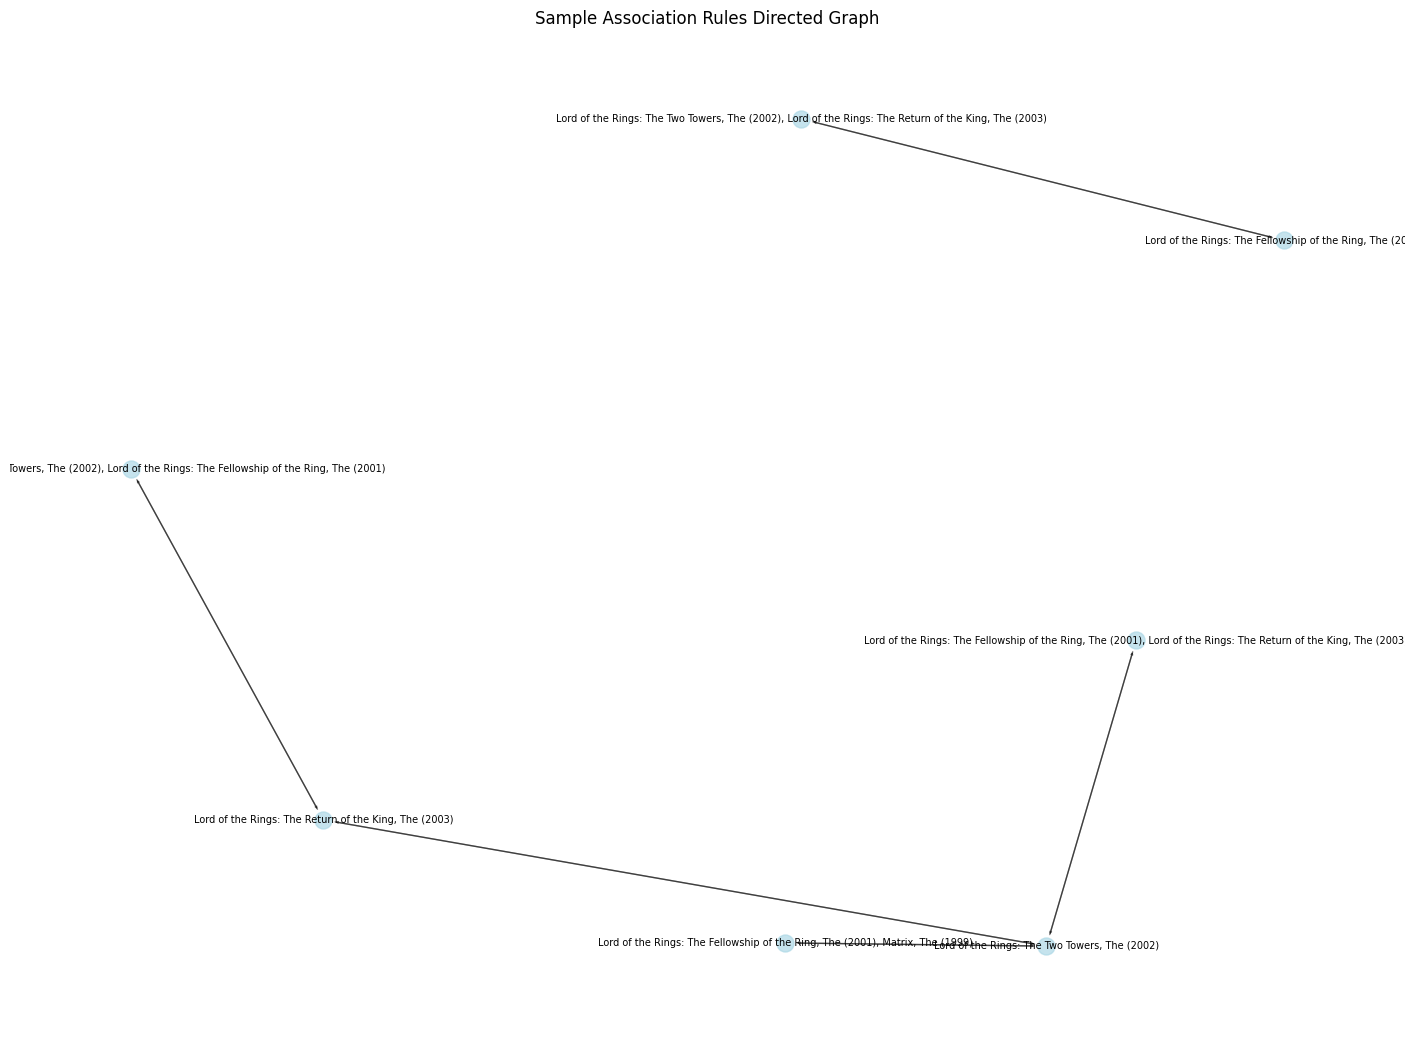

In [259]:
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
def plot_topk_rules_in_graph(rules, frequent_itemsets, k=10):

    # Create a directed graph
    G = nx.DiGraph()
    narrow_rules = rules.sort_values(by='lift', ascending=False).head(k)
    # Add nodes and directed edges
    for _, rule in narrow_rules.iterrows():
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))

        # Add a directed edge from antecedent to consequent
        G.add_edge(antecedent, consequent)

    # Draw the directed graph
    plt.figure(figsize=(18, 13))
    pos = nx.spring_layout(G, k=0.5, iterations=k)  # Layout for the graph

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=150, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=3)
    nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')

    # Add edge labels (optional, if you want to display lift, confidence, or support)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Sample Association Rules Directed Graph")
    plt.axis('off')
    plt.show()

plot_topk_rules_in_graph(rules, frequent_itemsets)

max lift value is 3.7135
max confidence value is 0.9567


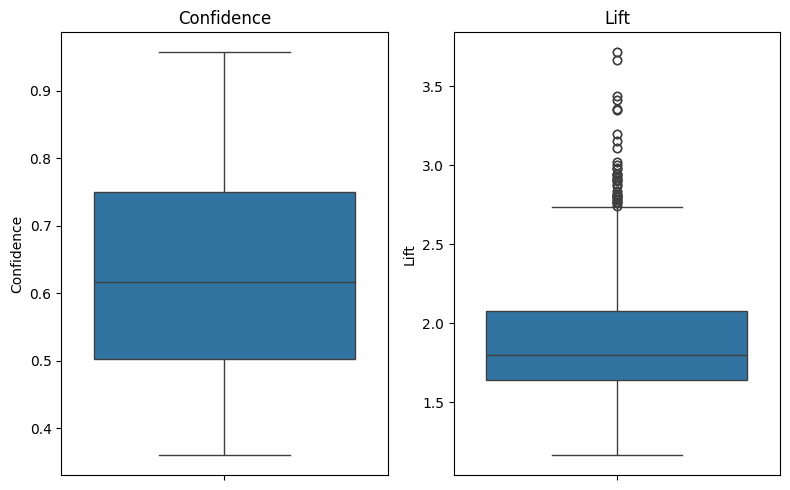

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics_boxplots(rules):
  if not rules.empty:


      print(f"max lift value is {rules['lift'].max():.4f}")
      print(f"max confidence value is {rules['confidence'].max():.4f}")

      fig, axes = plt.subplots(1, 2, figsize=(8, 5))

      # plot Confidence
      sns.boxplot(data=rules['confidence'], ax=axes[0])
      axes[0].set_title('Confidence')
      axes[0].set_ylabel('Confidence')

      # plot Lift
      sns.boxplot(data=rules['lift'], ax=axes[1])
      axes[1].set_title('Lift')
      axes[1].set_ylabel('Lift')

      # show plot
      plt.tight_layout()
      plt.show()
  else:
      print("No rules to plot.")



plot_metrics_boxplots(rules)


# Cluster items + Apriori


In [280]:
from sklearn.cluster import KMeans


def add_cluster_users_col(num_clusters, transactions_matrix):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    user_clusters = kmeans.fit_predict(transactions_matrix)
    transactions_matrix['Cluster'] = user_clusters


num_clusters = 50
add_cluster_users_col(num_clusters,transactions)
df = transactions

def  filter_valid_clusters_by_size(df):
  # Calculate the percentage of each cluster
  cluster_percentage = df['Cluster'].value_counts(normalize=True) * 100

  # Get the clusters with percentage >= 1
  valid_clusters = cluster_percentage[(cluster_percentage >= 1) & (cluster_percentage <= 30)].index

  # Filter the dataframe to include only rows from valid clusters
  df_filtered = df[df['Cluster'].isin(valid_clusters)]
  return df_filtered

df = filter_valid_clusters_by_size(df)

<ipython-input-262-f00be67c9607>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


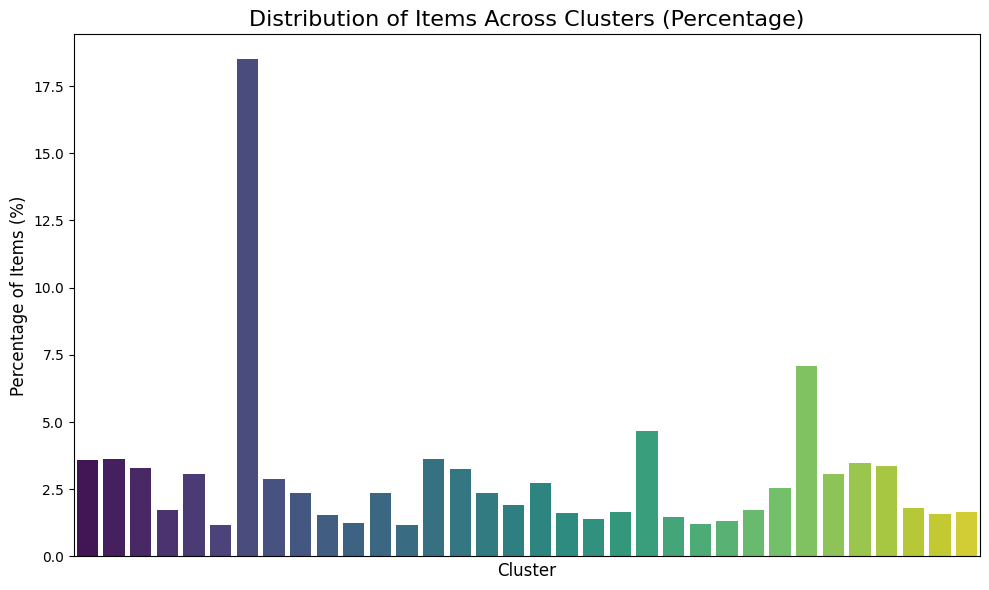

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cluster_distribution(df):
  # Get the distribution of clusters (as percentages only)
  cluster_percentages = (df['Cluster'].value_counts(normalize=True) * 100).sort_index()

  # Plot the distribution using seaborn barplot
  plt.figure(figsize=(10, 6))
  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')

  # Add labels and title
  plt.title('Distribution of Items Across Clusters (Percentage)', fontsize=16)
  plt.xlabel('Cluster', fontsize=12)
  plt.ylabel('Percentage of Items (%)', fontsize=12)

  # Remove x-tick labels (to avoid showing the cluster index)
  plt.xticks([])

  # Show the plot
  plt.tight_layout()
  plt.show()

plot_cluster_distribution(df)



Processing Cluster 0...
Sparsity of Cluster 0: 0.8711, ize of Cluster is: 627


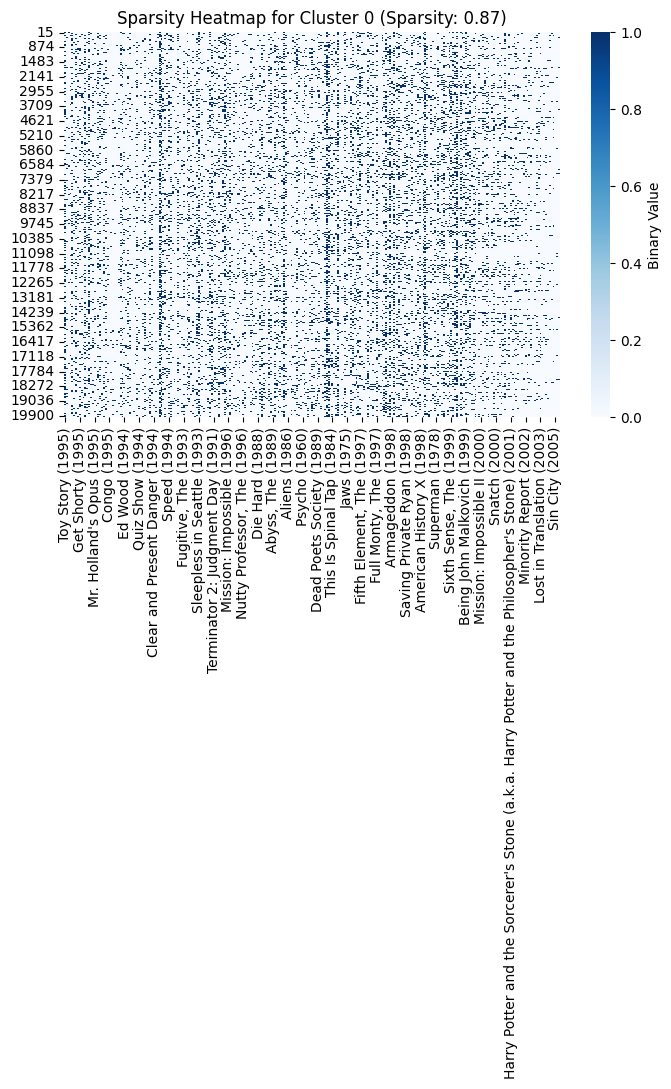

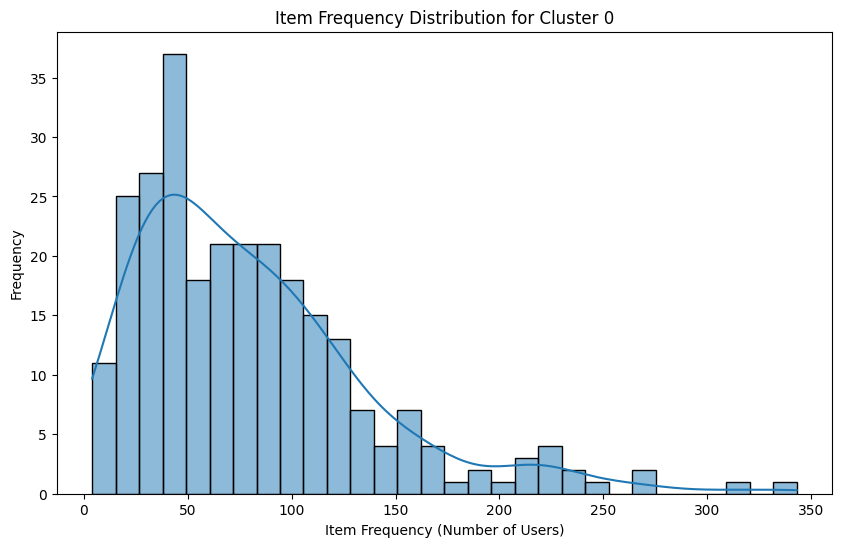

Cluster 0: 0 rules generated.

Processing Cluster 2...
Sparsity of Cluster 2: 0.8658, ize of Cluster is: 631


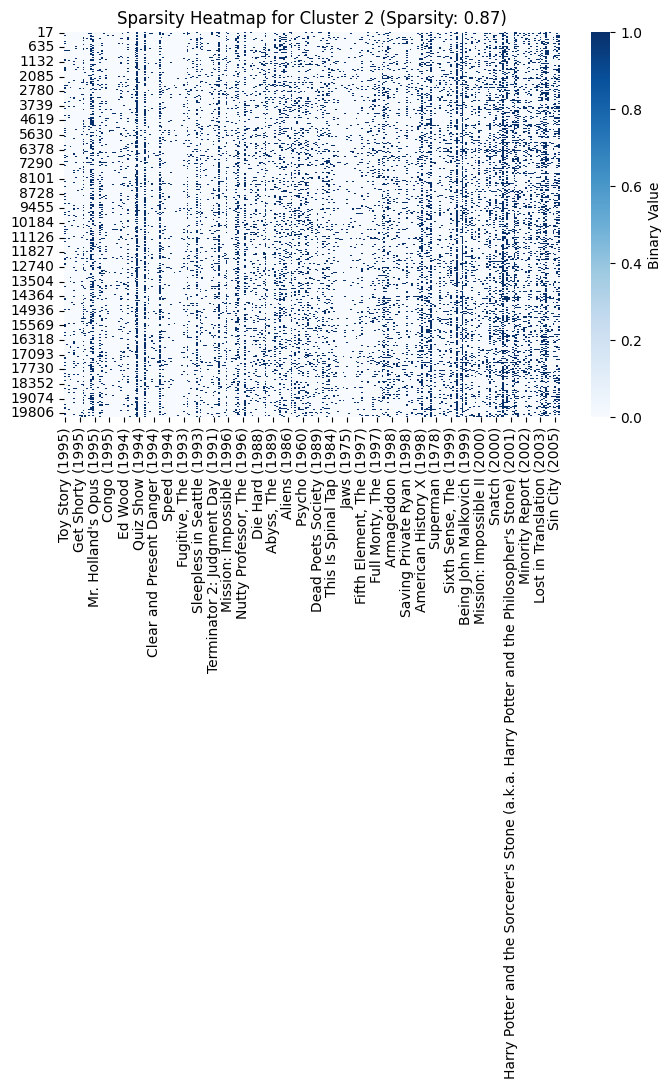

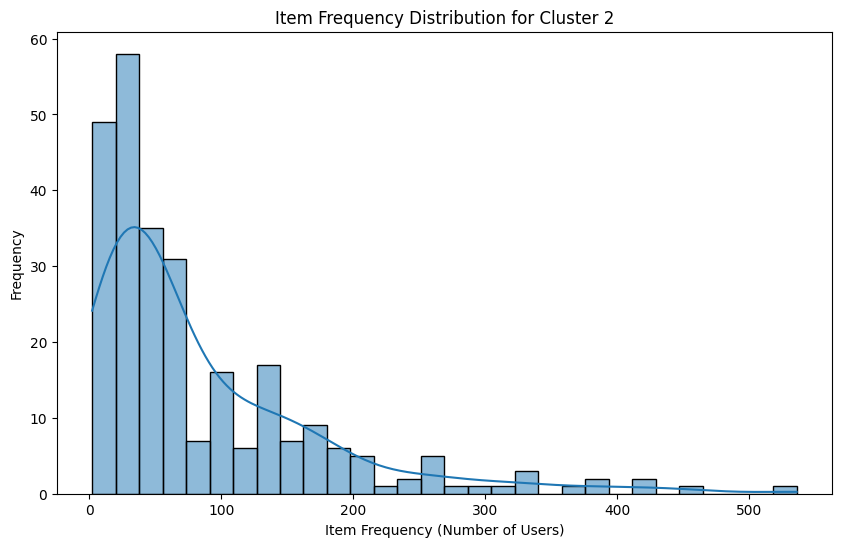

Cluster 2: 14 rules generated.

Processing Cluster 4...
Sparsity of Cluster 4: 0.8817, ize of Cluster is: 577


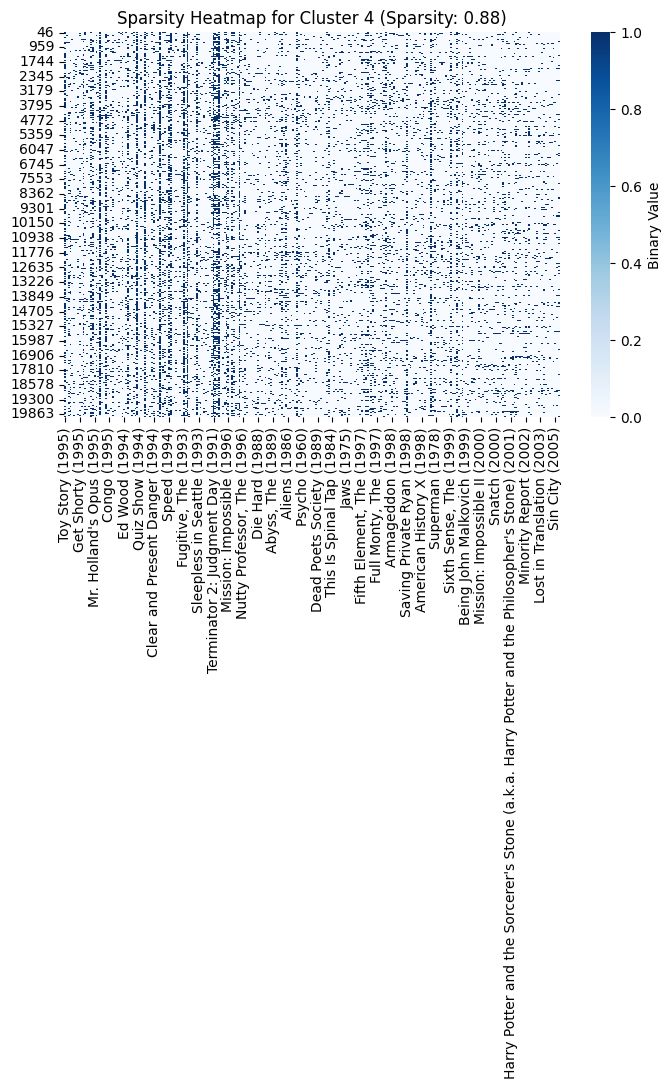

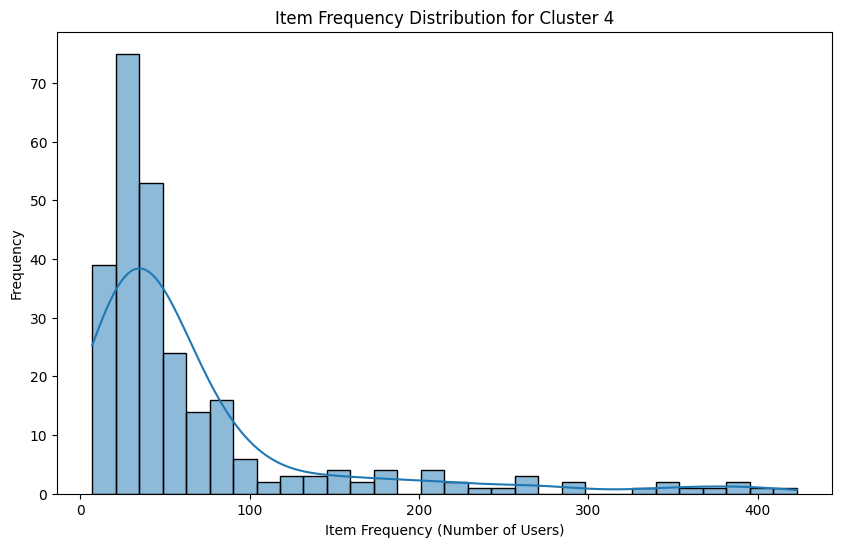

Cluster 4: 10 rules generated.

Processing Cluster 6...
Sparsity of Cluster 6: 0.9495, ize of Cluster is: 534


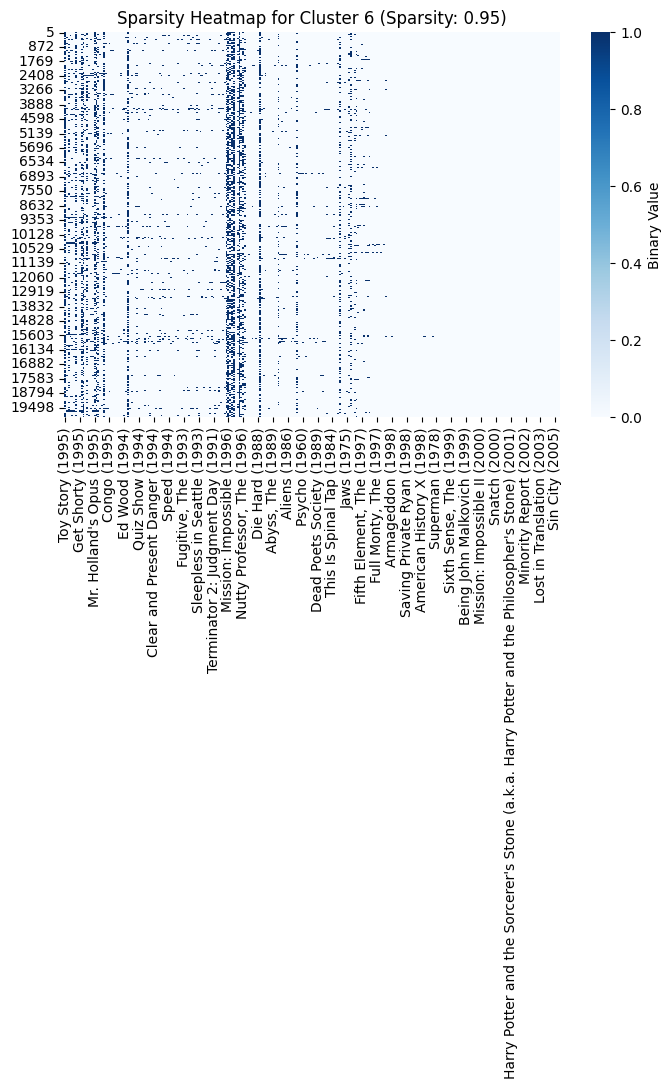

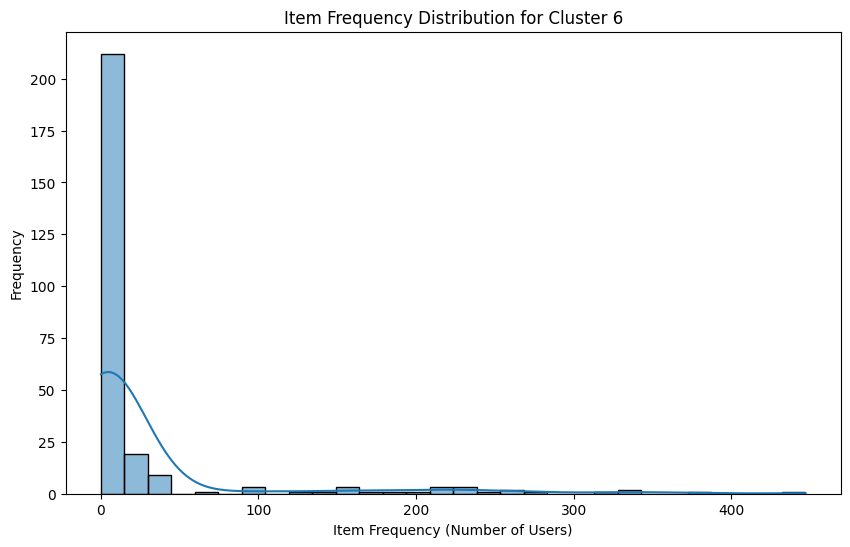

Cluster 6: 8 rules generated.

Processing Cluster 8...
Sparsity of Cluster 8: 0.9635, ize of Cluster is: 3226


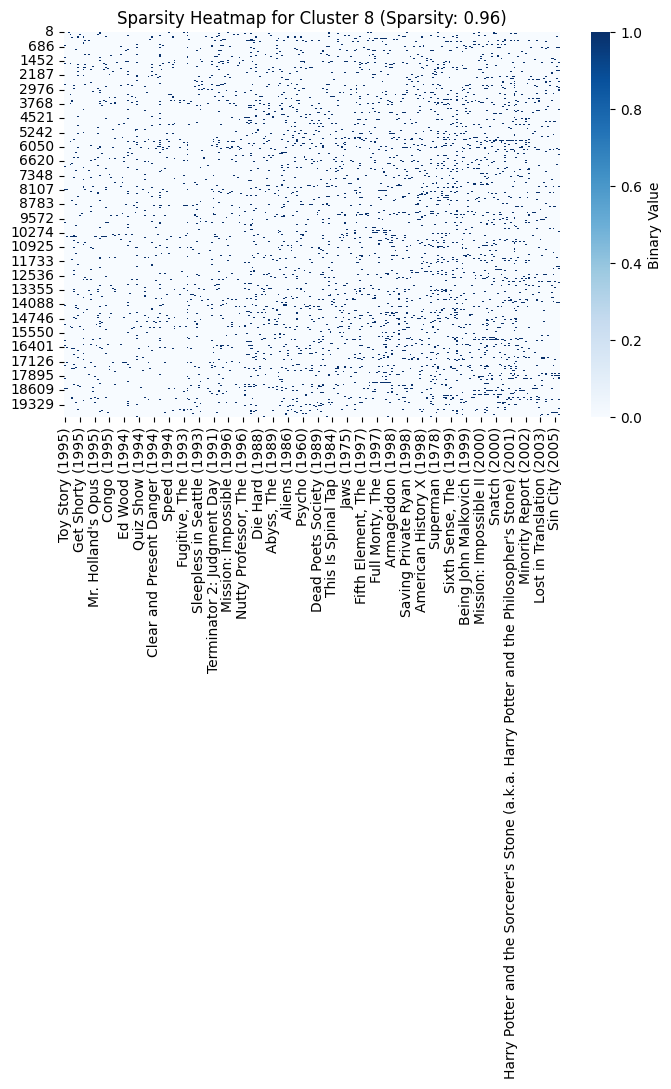

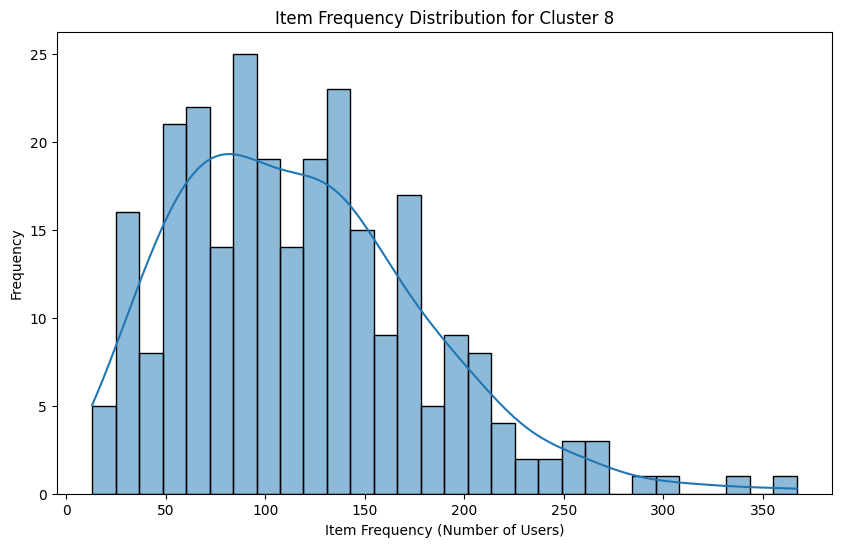

No frequent itemsets found in Cluster 8.

Processing Cluster 9...
Sparsity of Cluster 9: 0.8099, ize of Cluster is: 504


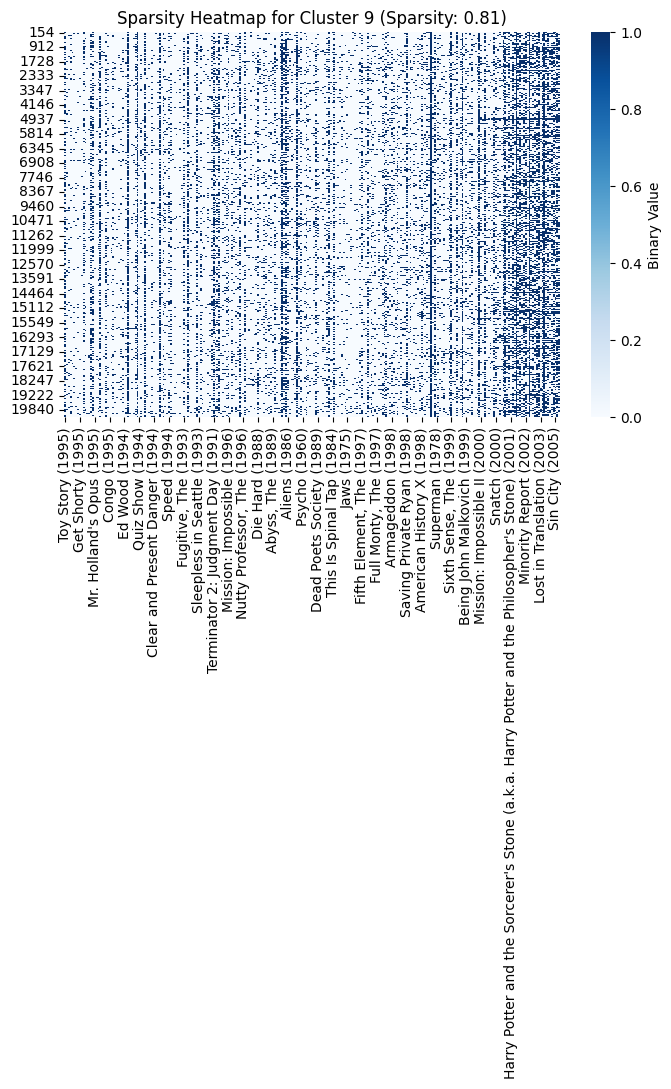

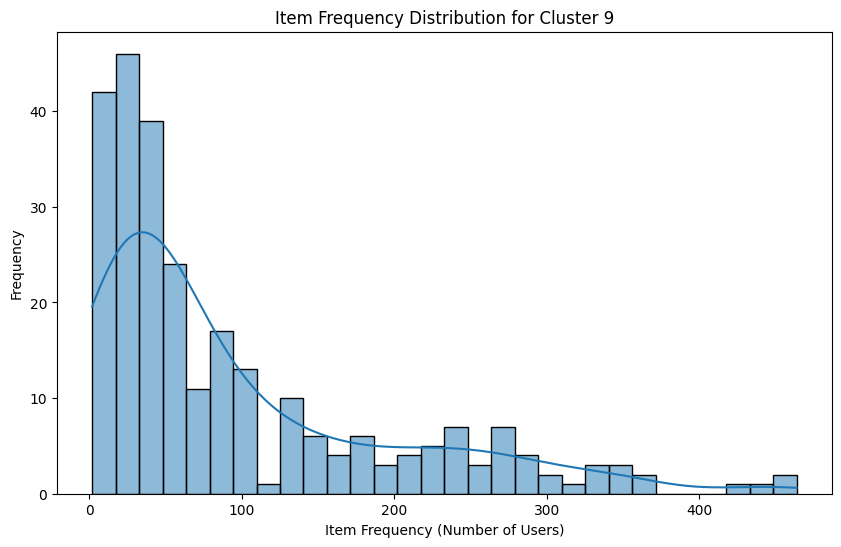

Cluster 9: 1178 rules generated.

Processing Cluster 15...
Sparsity of Cluster 15: 0.9251, ize of Cluster is: 630


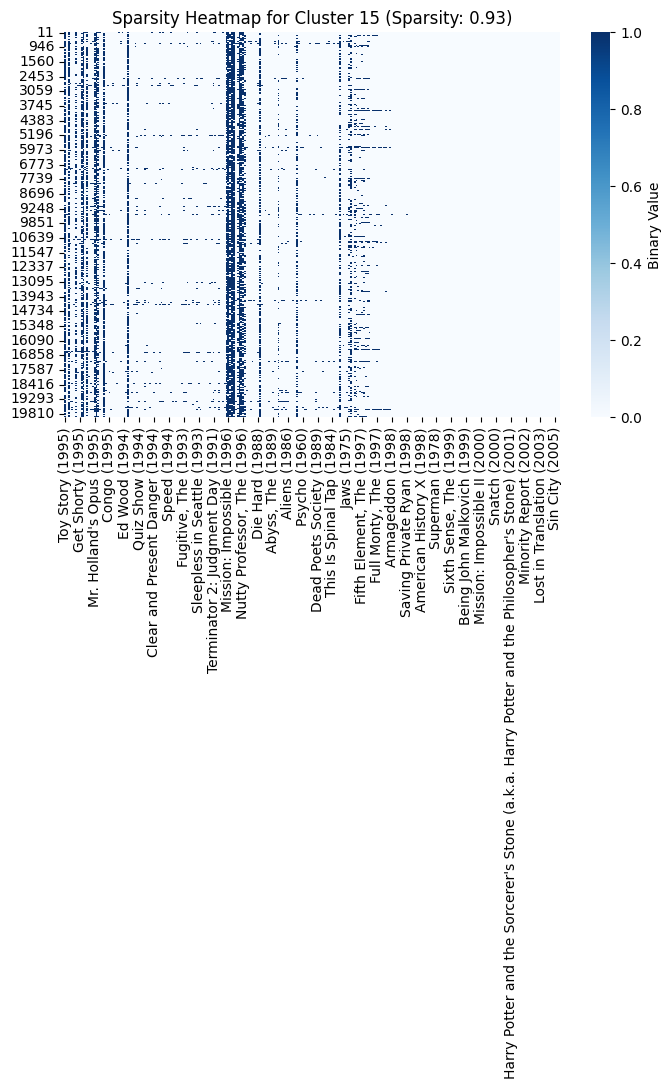

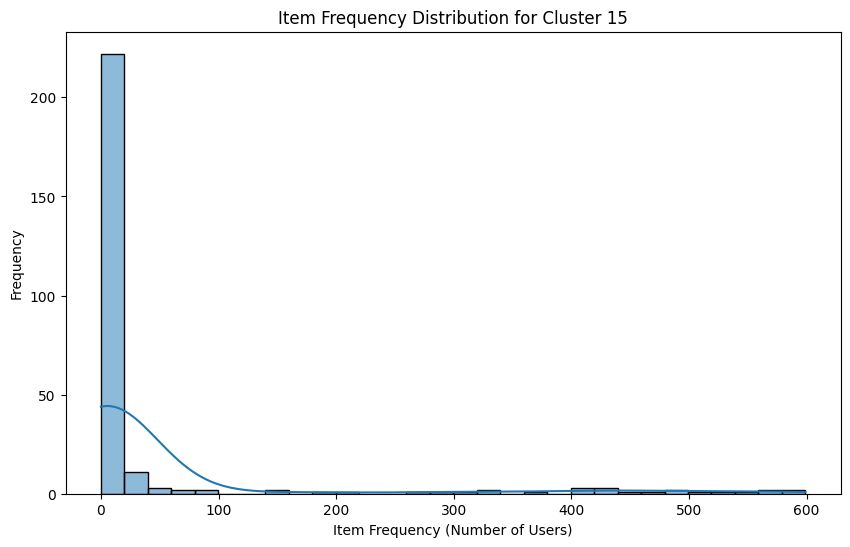

Cluster 15: 8076 rules generated.

Processing Cluster 16...
Sparsity of Cluster 16: 0.9038, ize of Cluster is: 566


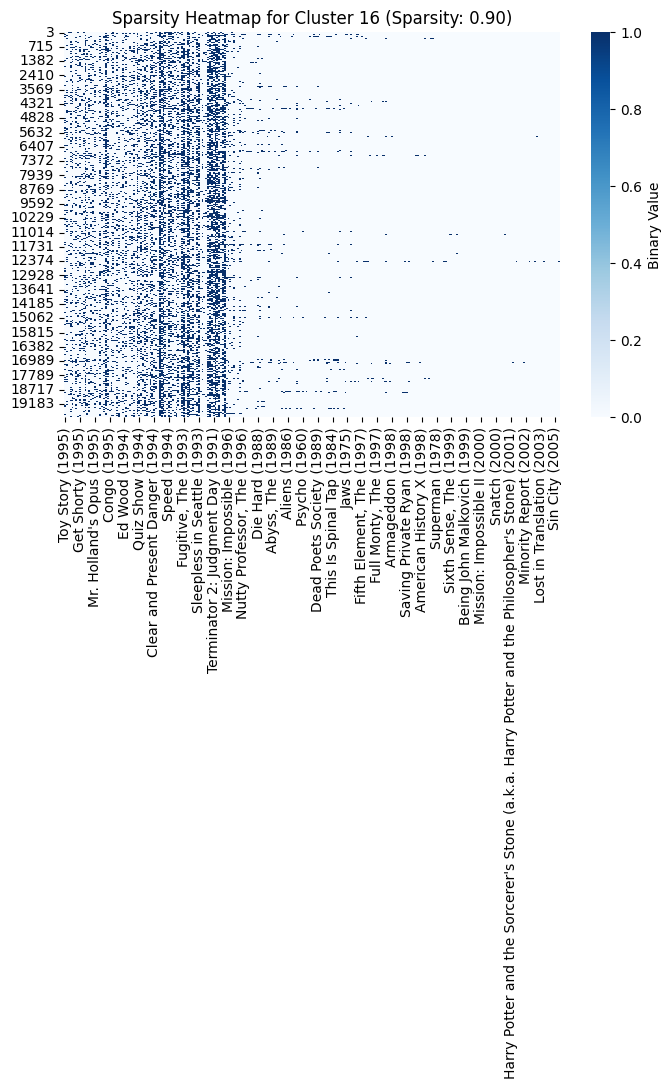

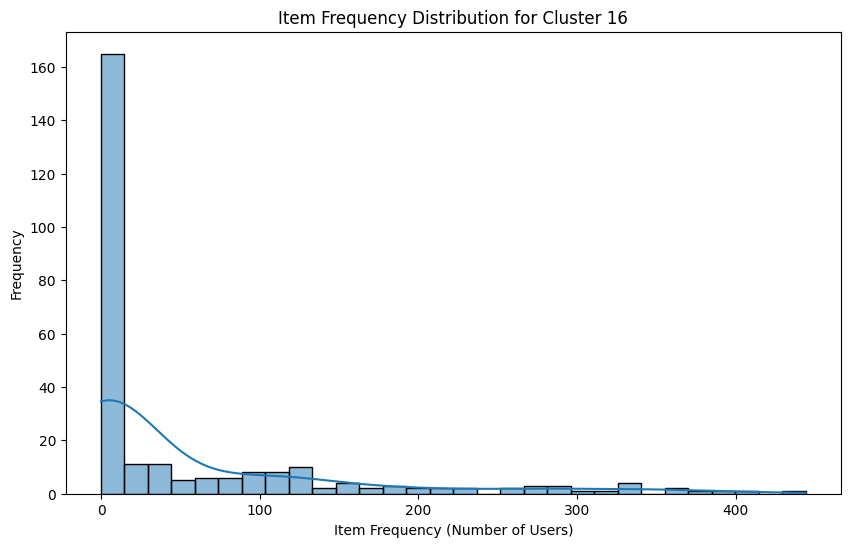

Cluster 16: 8 rules generated.

Processing Cluster 29...
Sparsity of Cluster 29: 0.9254, ize of Cluster is: 813


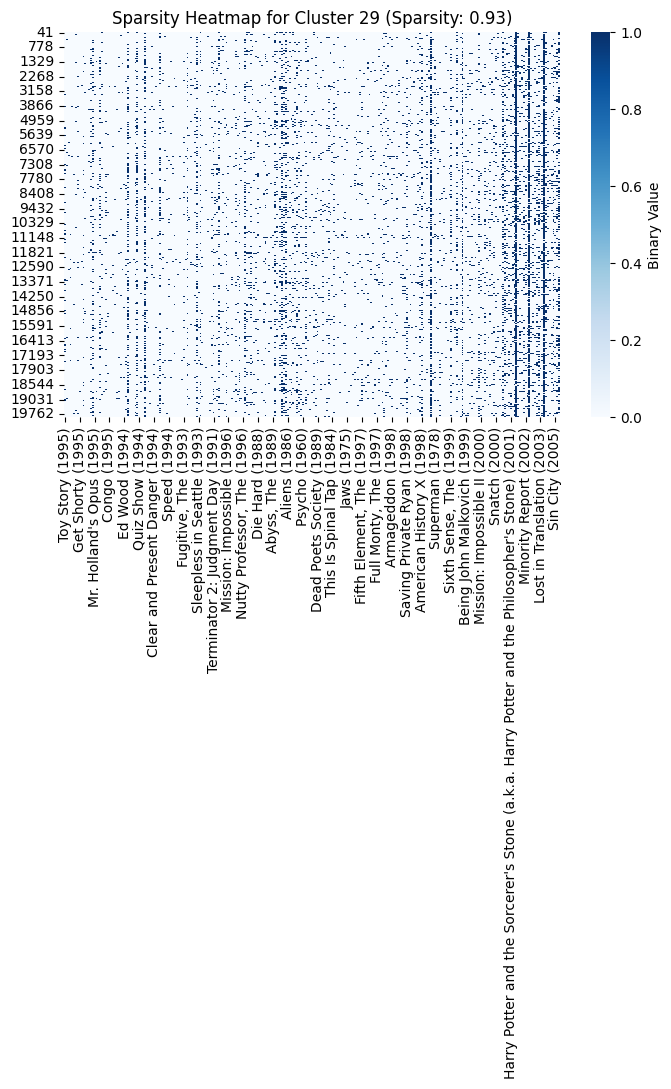

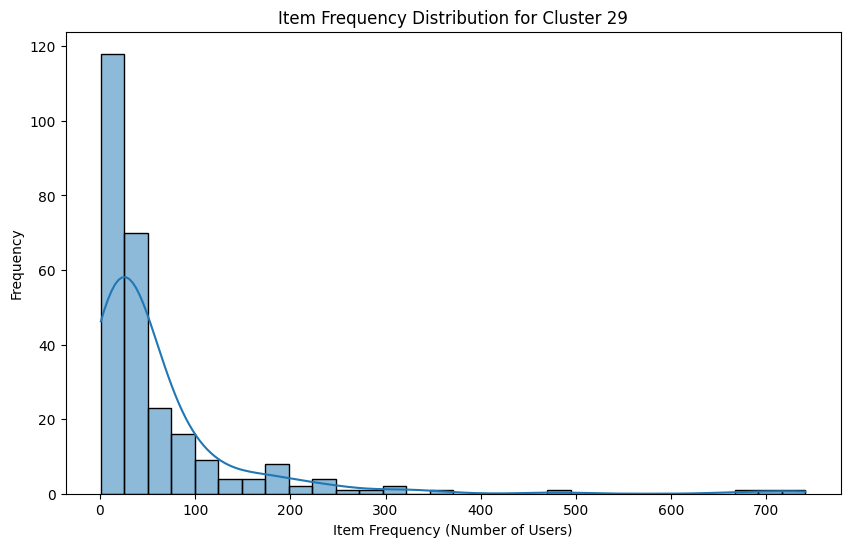

Cluster 29: 12 rules generated.

Processing Cluster 40...
Sparsity of Cluster 40: 0.9478, ize of Cluster is: 1236


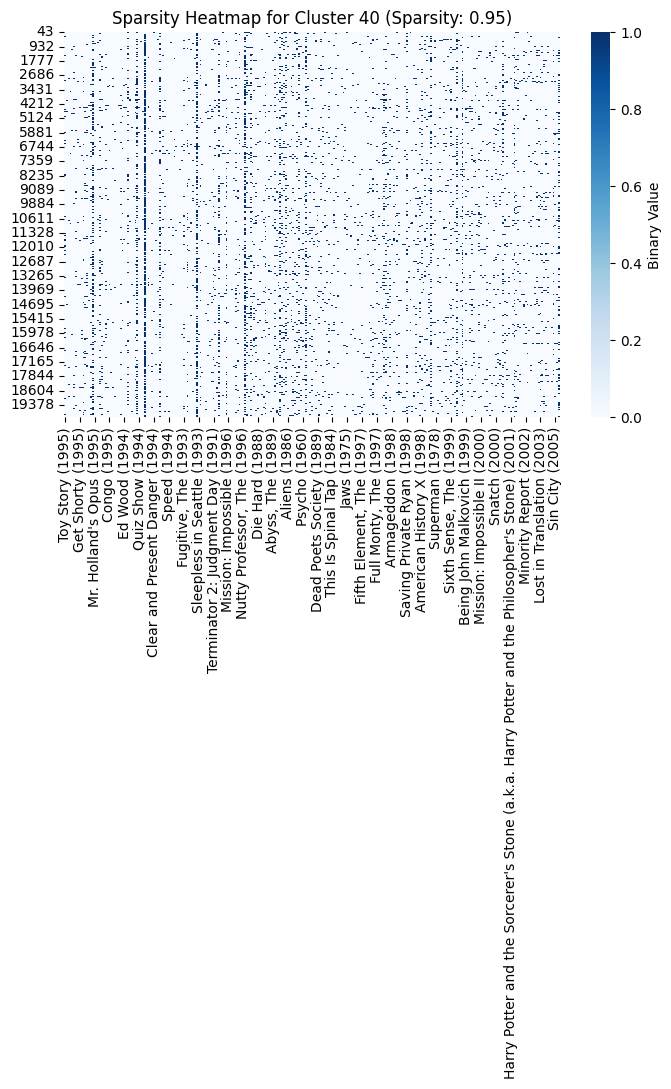

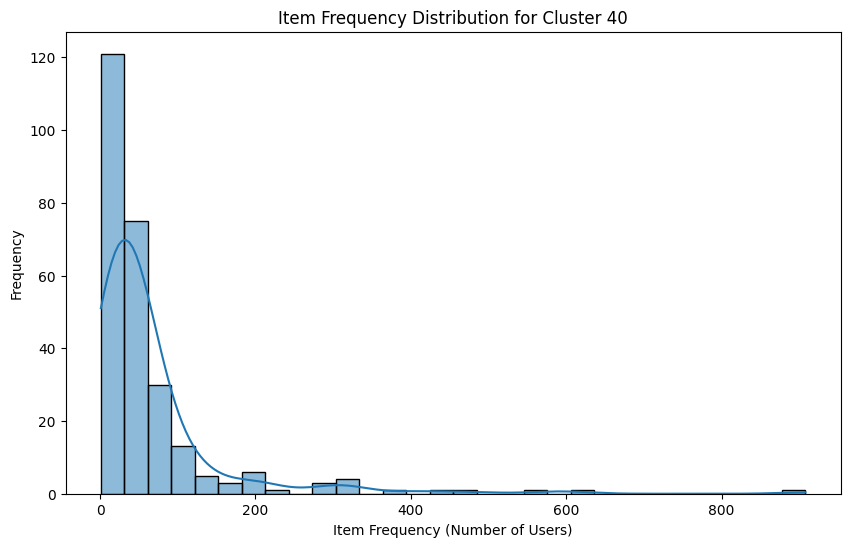

Cluster 40: 0 rules generated.

Processing Cluster 43...
Sparsity of Cluster 43: 0.9181, ize of Cluster is: 537


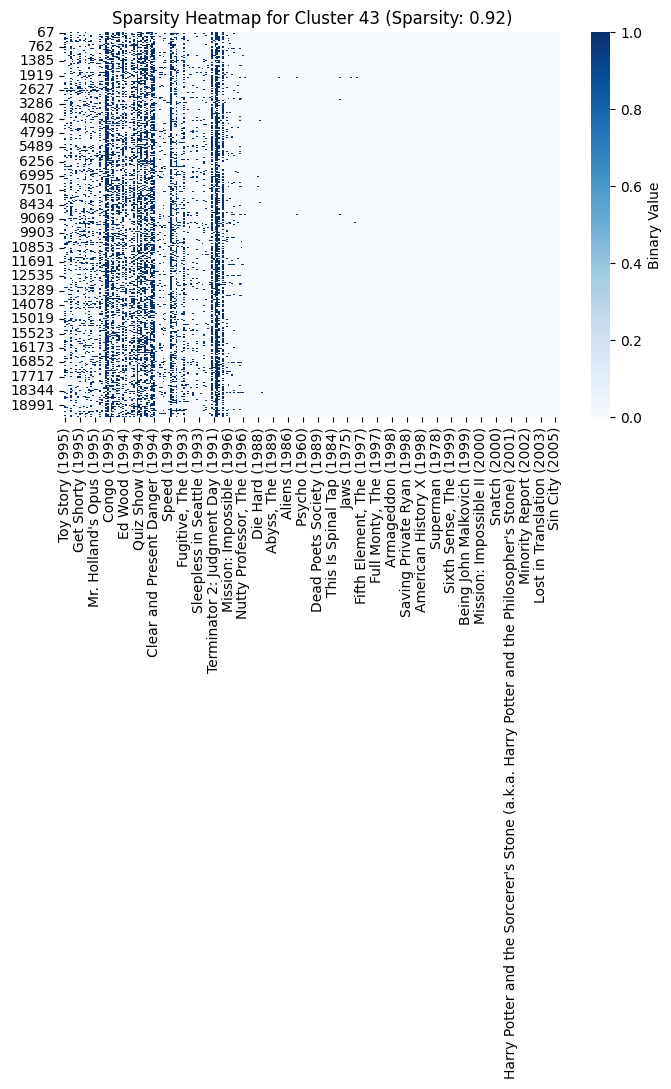

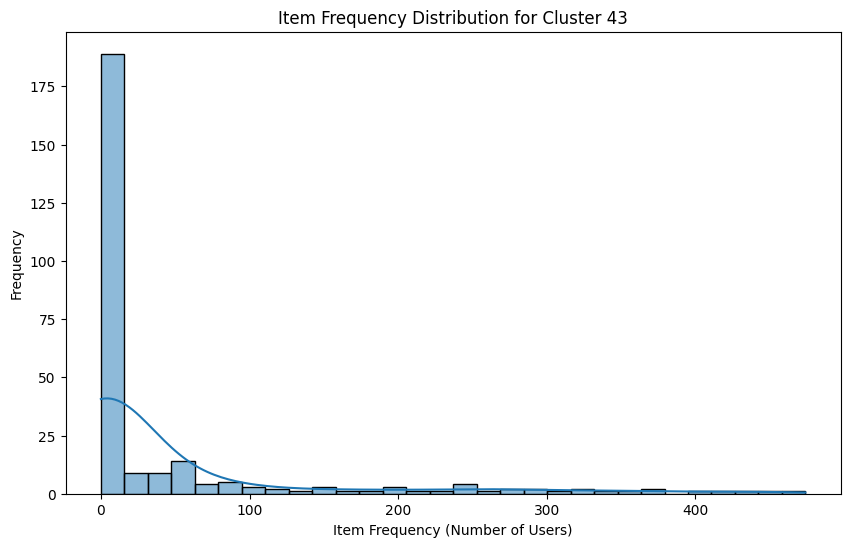

Cluster 43: 196 rules generated.

Processing Cluster 44...
Sparsity of Cluster 44: 0.8688, ize of Cluster is: 603


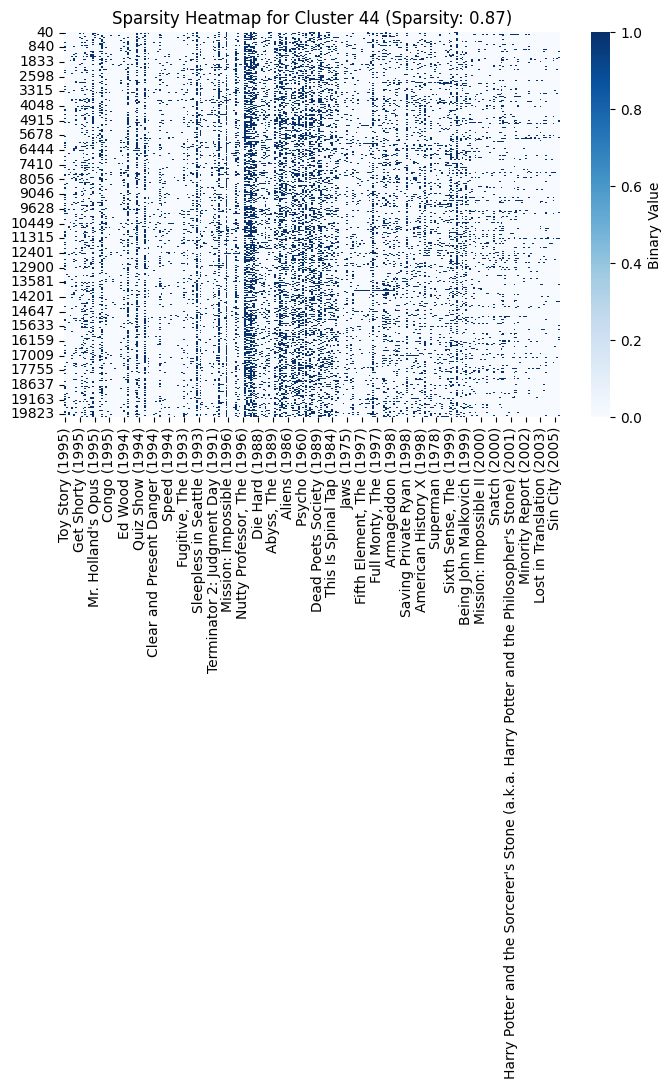

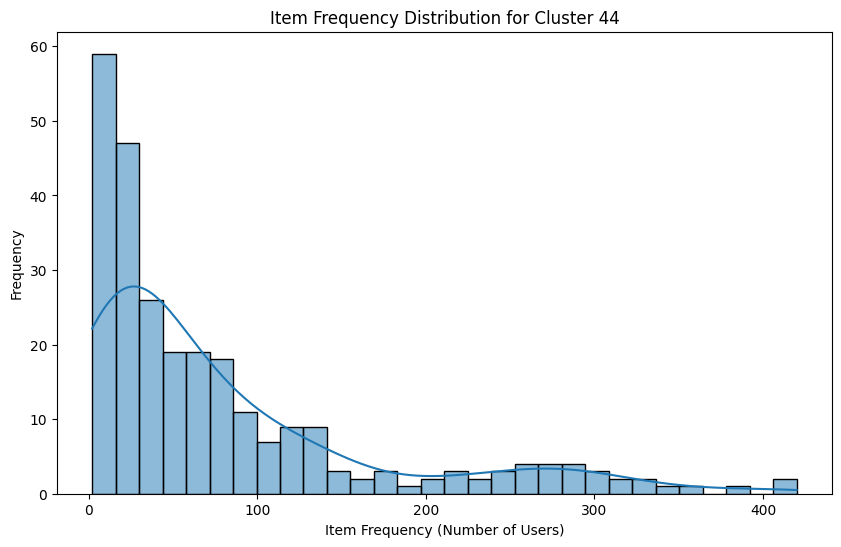

Cluster 44: 0 rules generated.

Processing Cluster 45...
Sparsity of Cluster 45: 0.8914, ize of Cluster is: 585


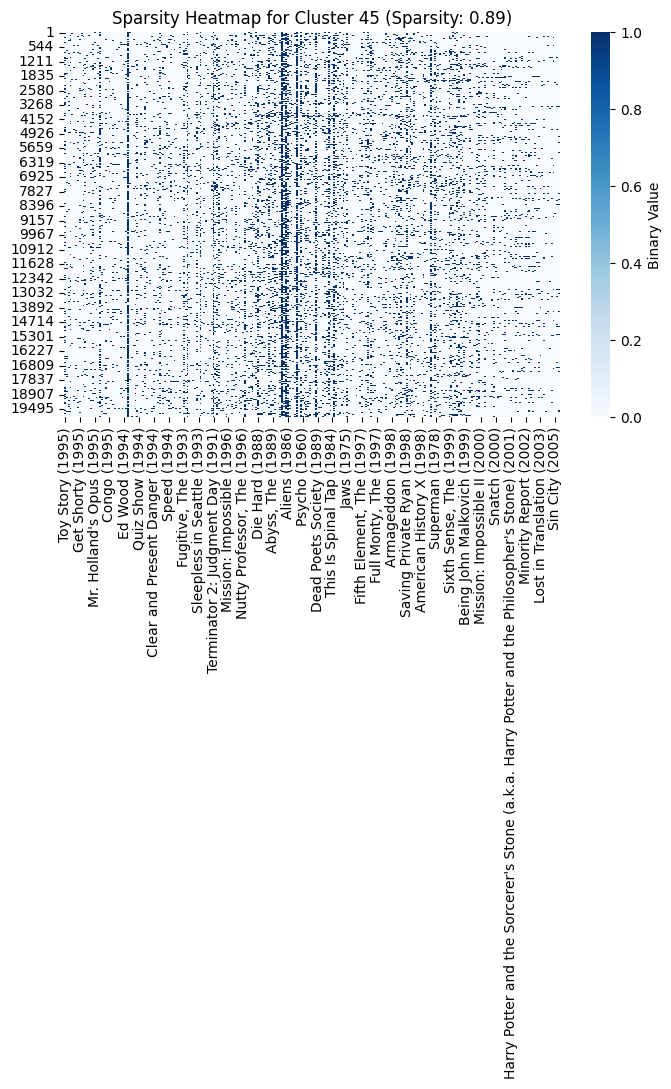

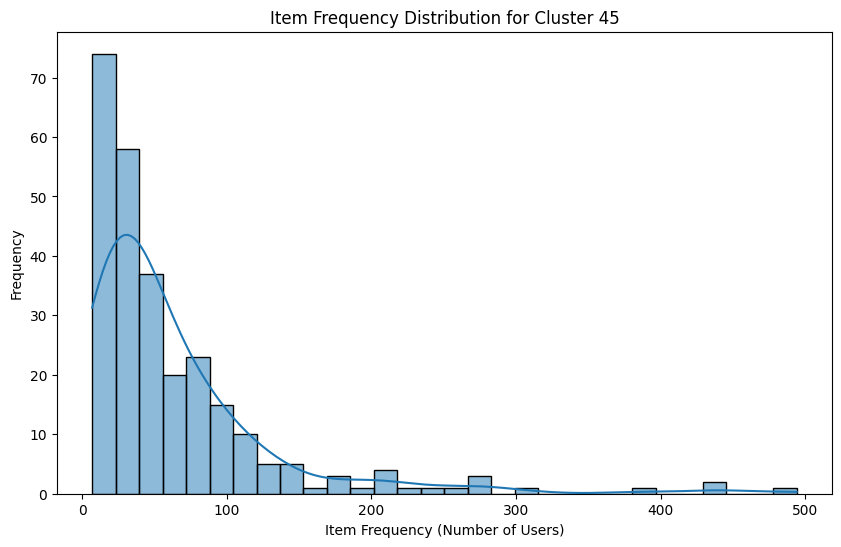

Cluster 45: 16 rules generated.


In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth

def calculate_sparsity(cluster_data):
    """Calculate the sparsity of the cluster data."""
    total_entries = cluster_data.size
    non_zero_entries = cluster_data.values.sum()
    return 1 - (non_zero_entries / total_entries)

def plot_sparsity(cluster_data, cluster_id):
    """Plot the sparsity of a cluster."""
    sparsity = calculate_sparsity(cluster_data)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cluster_data, cbar_kws={'label': 'Binary Value'}, cmap='Blues')
    plt.title(f"Sparsity Heatmap for Cluster {cluster_id} (Sparsity: {sparsity:.2f})")
    plt.show()

def plot_item_frequency_distribution(cluster_data, cluster_id):
    """Plot item frequency distribution for a cluster."""
    item_frequencies = cluster_data.sum(axis=0)  # Sum across rows to get item frequency
    plt.figure(figsize=(10, 6))
    sns.histplot(item_frequencies, bins=30, kde=True)
    plt.title(f"Item Frequency Distribution for Cluster {cluster_id}")
    plt.xlabel('Item Frequency (Number of Users)')
    plt.ylabel('Frequency')
    plt.show()

def process_cluster(cluster_id, df, min_support):
    print(f"\nProcessing Cluster {cluster_id}...")

    # Extract transactions of the current cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])

    # Calculate and print sparsity for this cluster
    sparsity = calculate_sparsity(cluster_data)
    print(f"Sparsity of Cluster {cluster_id}: {sparsity:.4f}, ize of Cluster is: {len(cluster_data)}")

    # Plot sparsity heatmap for this cluster
    plot_sparsity(cluster_data, cluster_id)

    # Plot item frequency distribution
    plot_item_frequency_distribution(cluster_data, cluster_id)

    # Run FPGrowth
    frequent_itemsets = fpgrowth(cluster_data, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        print(f"No frequent itemsets found in Cluster {cluster_id}.")
        return None

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    print(f"Cluster {cluster_id}: {len(rules)} rules generated.")
    return cluster_id, {"frequent_itemsets": frequent_itemsets, "rules": rules}

def find_clusters_rules(df, min_support):
    cluster_results = {}
    for cluster_id in sorted(df['Cluster'].unique()):

        cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])
        # Calculate and filter clusters with less sparsity than desired.
        if df['Cluster'].value_counts()[cluster_id] < 0.025 * len(transactions):
            cluster_results[cluster_id] = cluster_id, {"frequent_itemsets": None, "rules": None}
            continue
        cluster_results[cluster_id] = process_cluster(cluster_id, df, min_support)
    return cluster_results

cluster_results = find_clusters_rules(transactions, min_support=0.5)


In [264]:
from sklearn.metrics import silhouette_score

score=silhouette_score(df, df['Cluster'])
print(f"silhouette score of clustering is: {score}")


silhouette score of clustering is: 0.14503115893153914


In [265]:

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered in divide*")
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*DataFrames with non-bool types result in worse computationalperformance*")

from mlxtend.frequent_patterns import fpgrowth, association_rules
import numpy as np

# Function to compute global support
import numpy as np

def calculate_global_support(itemset, full_data):
    """Calculate global support of an itemset across the entire transactions dataset efficiently."""
    itemset = list(itemset)  # Ensure itemset is a list
    relevant_rows = full_data[itemset].sum(axis=1) == len(itemset)  # Check if all items are present
    return relevant_rows.mean()  # Equivalent to sum(relevant_rows) / len(full_data)


In [266]:
import pandas as pd

def calculate_global_support(itemset, full_data):
    """Calculate global support of an itemset across the entire transactions dataset efficiently."""
    itemset = list(itemset)  # Ensure itemset is a list
    relevant_rows = full_data[itemset].sum(axis=1) == len(itemset)  # Check if all items are present
    return relevant_rows.mean()

def aggregate_all_rules(cluster_results, transactions, original_min_support):
    # Initialize an empty list to store all the rules
    all_rules = []

    # Loop through all cluster results and combine the rules
    for id, cluster_data in cluster_results.items():
        if cluster_data is None:
            continue
        rules = cluster_data[1]["rules"]
        if rules is None or rules.empty:
            continue
        rules['Cluster'] = id
        all_rules.append(rules)

    # Concatenate all the rules into a single DataFrame
    all_rules_df = pd.concat(all_rules, ignore_index=True)
    # Remove duplicates if needed
    all_rules_df = all_rules_df.drop_duplicates(subset=['antecedents', 'consequents'])



    # Now calculate the global metrics for all rules in one go
    all_rules_df['global_antecedent_support'] = all_rules_df['antecedents'].apply(
        lambda x: calculate_global_support(set(x), transactions)
    )

    all_rules_df['global_consequent_support'] = all_rules_df['consequents'].apply(
        lambda x: calculate_global_support(set(x), transactions)
    )

    # Calculate global rule support (for antecedent + consequent together)
    all_rules_df['global_rule_support'] = all_rules_df.apply(
        lambda row: calculate_global_support(set(row['antecedents']).union(set(row['consequents'])) , transactions),
        axis=1
    )

    # Calculate global confidence
    all_rules_df['global_confidence'] = all_rules_df['global_rule_support'] / all_rules_df['global_antecedent_support']

    # Calculate global lift
    all_rules_df['global_lift'] = all_rules_df['global_confidence'] / all_rules_df['global_consequent_support']


    comparable_rules = all_rules_df[all_rules_df['global_rule_support'] >= original_min_support]
    print(f"number of rules shared with baseline approach: {len(comparable_rules)}")
    print(f"ratio of shared rules: {len(comparable_rules) / max(len(all_rules_df), 1)}")


    return all_rules_df



In [267]:
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)

number of rules shared with baseline approach: 228
ratio of shared rules: 0.02404556000843704


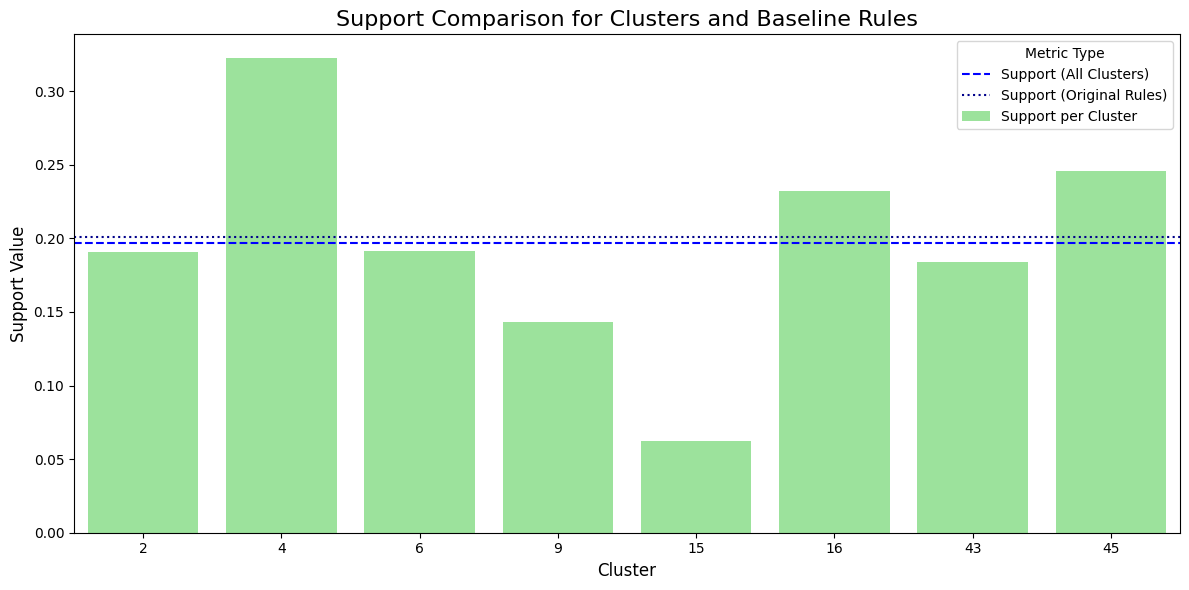

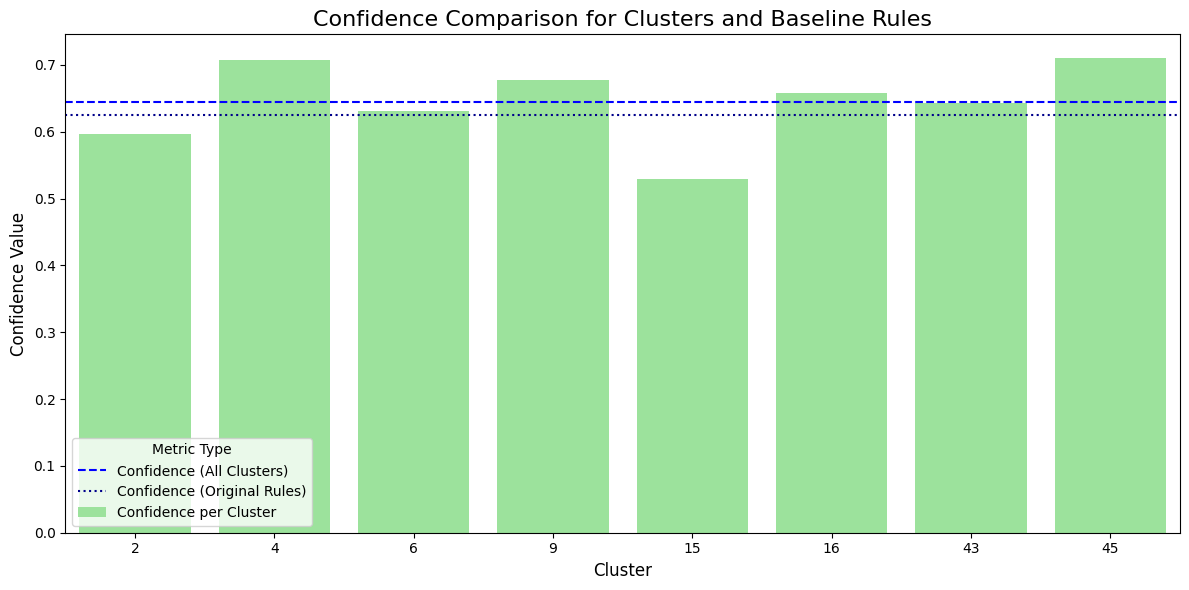

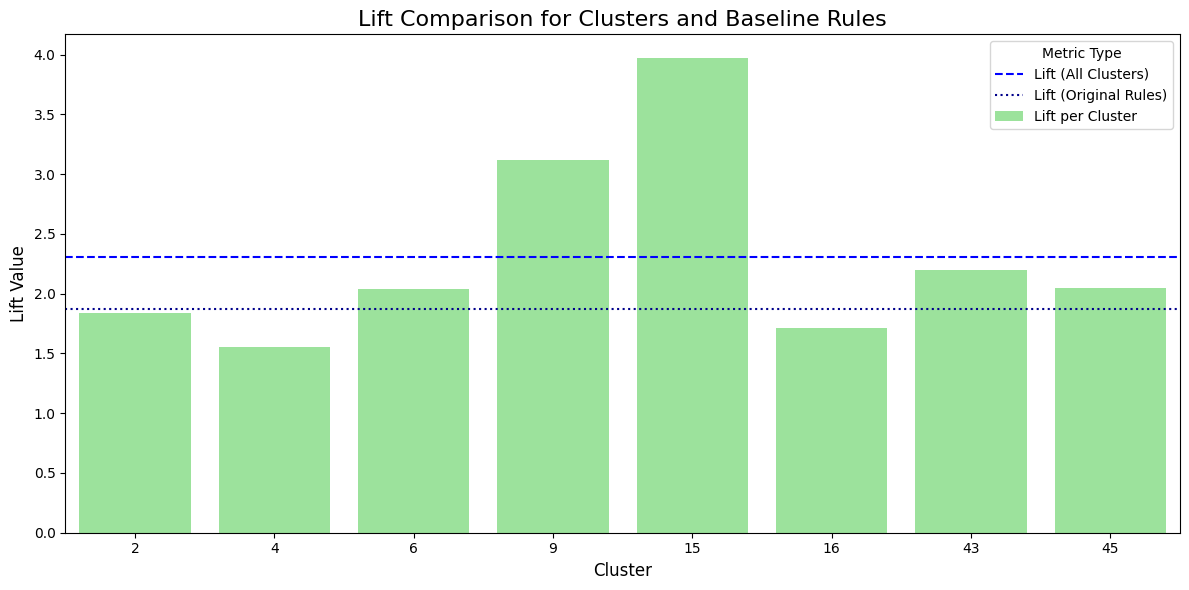

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_rules_comparison(all_rules_df):
  # Ensure overall_metrics is properly initialized
  overall_metrics = {
      'Support': {},
      'Confidence': {},
      'Lift': {}
  }

  # Group the rules by cluster and calculate the mean for each metric
  cluster_metrics_df = all_rules_df.groupby('Cluster')[['global_rule_support', 'global_confidence', 'global_lift']].mean().reset_index()

  # Compute global averages for all clusters
  if not cluster_metrics_df.empty:
      avg_support_all_clusters = cluster_metrics_df['global_rule_support'].mean()
      avg_confidence_all_clusters = cluster_metrics_df['global_confidence'].mean()
      avg_lift_all_clusters = cluster_metrics_df['global_lift'].mean()
  else:
      avg_support_all_clusters = avg_confidence_all_clusters = avg_lift_all_clusters = 0

  # Add overall metrics for all clusters
  overall_metrics['Support']['All Clusters'] = avg_support_all_clusters
  overall_metrics['Confidence']['All Clusters'] = avg_confidence_all_clusters
  overall_metrics['Lift']['All Clusters'] = avg_lift_all_clusters

  # Compute metrics for original rules
  if original_rules is not None and not original_rules.empty:
      avg_support_original = original_rules["support"].mean()
      avg_confidence_original = original_rules["confidence"].mean()
      avg_lift_original = original_rules["lift"].mean()
  else:
      avg_support_original = avg_confidence_original = avg_lift_original = 0

  # Add original rules metrics to overall metrics
  overall_metrics['Support']['Original Rules'] = avg_support_original
  overall_metrics['Confidence']['Original Rules'] = avg_confidence_original
  overall_metrics['Lift']['Original Rules'] = avg_lift_original

  # Prepare the data for plotting each metric separately
  metrics = ['global_rule_support', 'global_confidence', 'global_lift']
  metric_mapping = {'global_rule_support': 'Support', 'global_confidence': 'Confidence', 'global_lift': 'Lift'}

  # Create individual plots for each metric
  for metric in metrics:
      fig, ax = plt.subplots(figsize=(12, 6))

      # Plot the metrics for each cluster
      sns.barplot(x='Cluster', y=metric, data=cluster_metrics_df, color='lightgreen', label=f'{metric_mapping[metric]} per Cluster', ax=ax)

      # Plot overall metrics (all clusters and original rules)
      ax.axhline(y=overall_metrics[metric_mapping[metric]]['All Clusters'], color='blue', linestyle='--', label=f'{metric_mapping[metric]} (All Clusters)')
      ax.axhline(y=overall_metrics[metric_mapping[metric]]['Original Rules'], color='darkblue', linestyle=':', label=f'{metric_mapping[metric]} (Original Rules)')

      # Add labels and title
      ax.set_title(f'{metric_mapping[metric]} Comparison for Clusters and Baseline Rules', fontsize=16)
      ax.set_xlabel('Cluster', fontsize=12)
      ax.set_ylabel(f'{metric_mapping[metric]} Value', fontsize=12)
      ax.legend(title='Metric Type')

      # Show the plot
      plt.tight_layout()
      plt.show()

plot_rules_comparison(all_rules_df)


# 2. Online Retail Datsaset

In [269]:
transactions = pd.read_csv("/content/TabularDS/final_project/data/online_retail_transactional.csv")
transactions.head()

10 COLOUR SPACEBOY PEN  12 MESSAGE CARDS WITH ENVELOPES  \
0                       0                                0   
1                       0                                0   
2                       0                                0   
3                       0                                0   
4                       0                                0   

   12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT  \
0                              0                                    0   
1                              0                                    0   
2                              0                                    0   
3                              0                                    0   
4                              0                                    0   

   12 PENCILS SMALL TUBE SKULL  12 PENCILS TALL TUBE POSY  \
0                            0                          0   
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                            0                          0   

   12 PENCILS TALL TUBE RED RETROSPOT  12 PENCILS TALL TUBE SKULLS  \
0                                   0                            0   
1                                   0                            0   
2                                   0                            0   
3                                   0                            0   
4                                   0                            0   

   12 PENCILS TALL TUBE WOODLAND  15CM CHRISTMAS GLASS BALL 20 LIGHTS  ...  \
0                              0                                    0  ...   
1                              0                                    0  ...   
2                              0                                    0  ...   
3                              0                                    0  ...   
4                              0                                    0  ...   

   WORLD WAR 2 GLIDERS ASSTD DESIGNS  WRAP 50'S  CHRISTMAS  \
0                                  0                     0   
1                                  0                     0   
2                                  0                     0   
3                                  0                     0   
4                                  0                     0   

   WRAP ALPHABET DESIGN  WRAP ENGLISH ROSE   YOU'RE CONFUSING ME METAL SIGN   \
0                     0                   0                                0   
1                     0                   0                                0   
2                     0                   0                                0   
3                     0                   0                                0   
4                     0                   0                                0   

   ZINC FOLKART SLEIGH BELLS  ZINC HERB GARDEN CONTAINER  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          1                           0   
4                          0                           0   

   ZINC METAL HEART DECORATION  ZINC T-LIGHT HOLDER STARS SMALL  \
0                            0                                0   
1                            0                                0   
2                            0                                0   
3                            0                                0   
4                            0                                0   

   ZINC WILLIE WINKIE  CANDLE STICK  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  

[5 rows x 633 columns]

In [270]:
import pandas as pd
min_support = 0.05
original_min_support = min_support

In [271]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

In [272]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 240
                          antecedents                         consequents  \
0          (REGENCY CAKESTAND 3 TIER)  (ROSES REGENCY TEACUP AND SAUCER )   
1  (ROSES REGENCY TEACUP AND SAUCER )          (REGENCY CAKESTAND 3 TIER)   
2   (PACK OF 72 RETROSPOT CAKE CASES)       (60 TEATIME FAIRY CAKE CASES)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.206512            0.099535  0.075581    0.365991  3.677012   
1            0.099535            0.206512  0.075581    0.759346  3.677012   
2            0.148140            0.096744  0.063023    0.425432  4.397491   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.055026    1.420272       0.917518  0.327952   0.295909   
1               1.0  0.055026    3.297214       0.808516  0.327952   0.696714   
2               1.0  0.048692    1.572060       0.906953  0.346547   0.363892   

   kulczynski  
0    0.562668  
1

In [273]:
import numpy as np

print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.0580, Confidence average: 0.5710, Lift average: 5.6758


In [281]:
from sklearn.cluster import KMeans

num_clusters = 40
add_cluster_users_col(num_clusters,transactions)
df = transactions

silhouette score of clustering is: 0.06553989781062255


<ipython-input-262-f00be67c9607>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


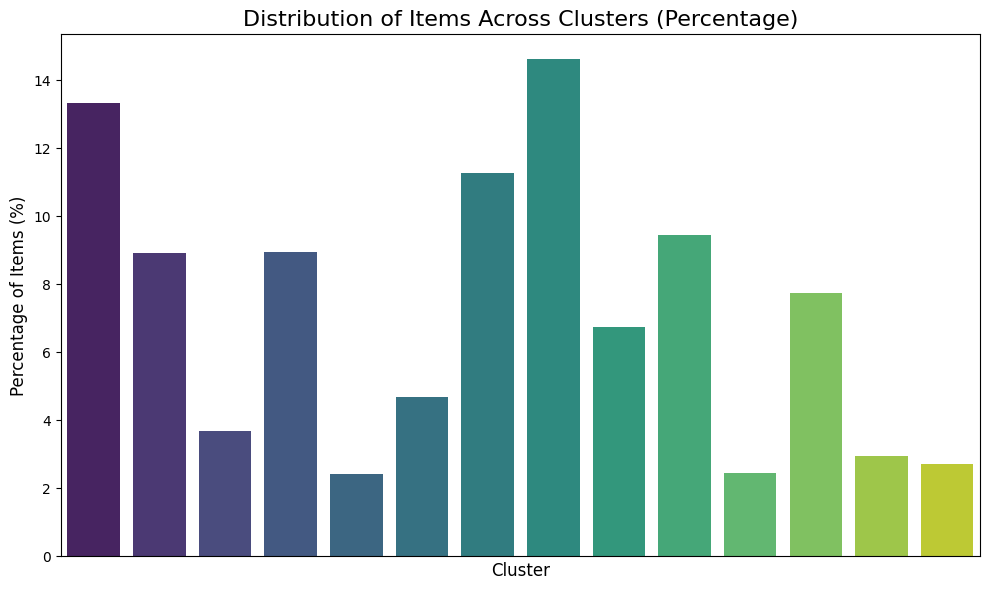

In [282]:
from sklearn.metrics import silhouette_score

score=silhouette_score(df, df['Cluster'])
print(f"silhouette score of clustering is: {score}")

plot_cluster_distribution(df)


# filter extreme clusters by size. (containing less than 1% or more than 30% of the transactions)
df = filter_valid_clusters_by_size(df)


Processing Cluster 0...
Sparsity of Cluster 0: 0.9491, ize of Cluster is: 330


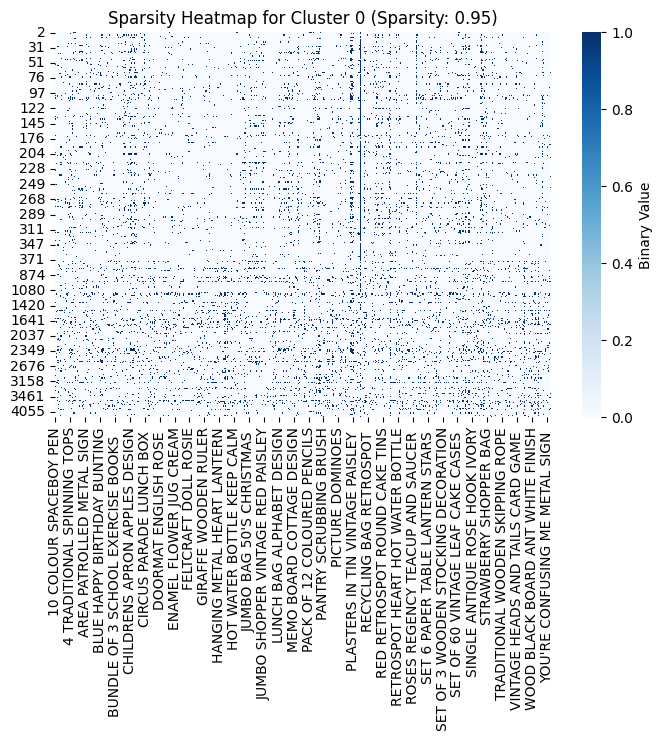

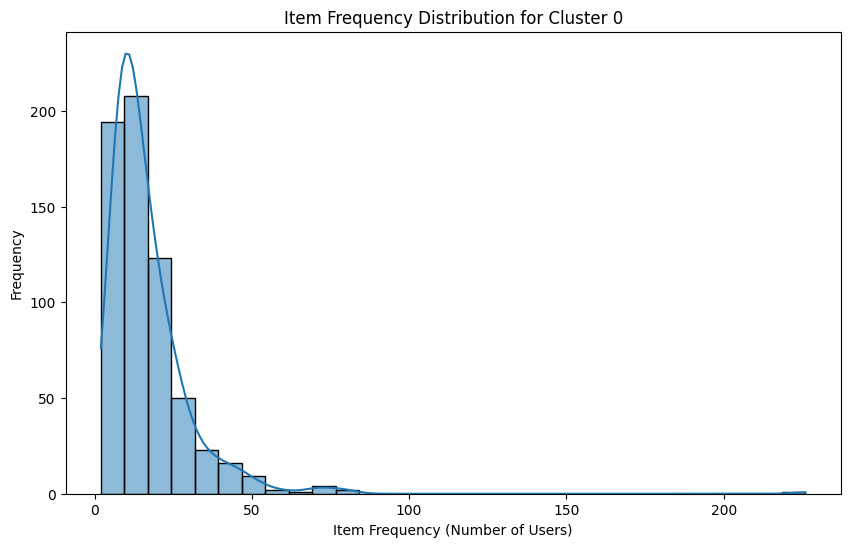

Cluster 0: 0 rules generated.

Processing Cluster 2...
Sparsity of Cluster 2: 0.9156, ize of Cluster is: 221


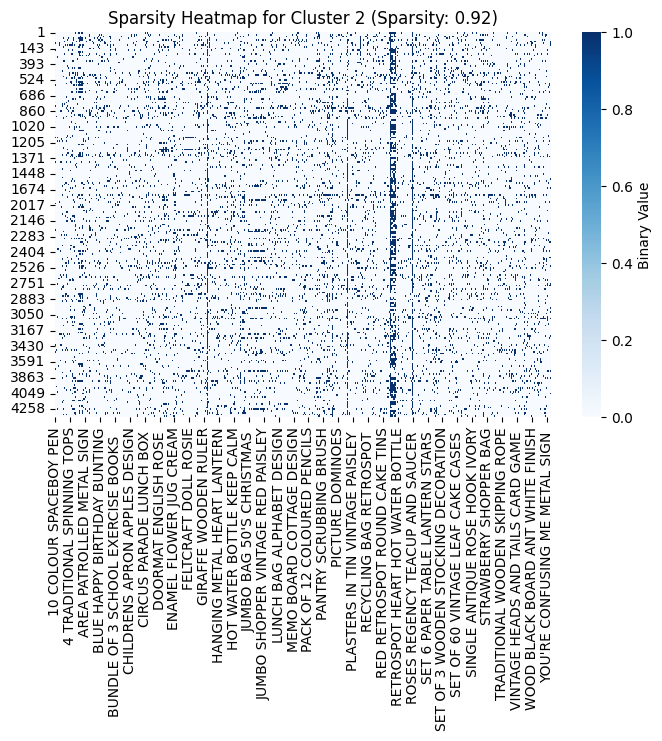

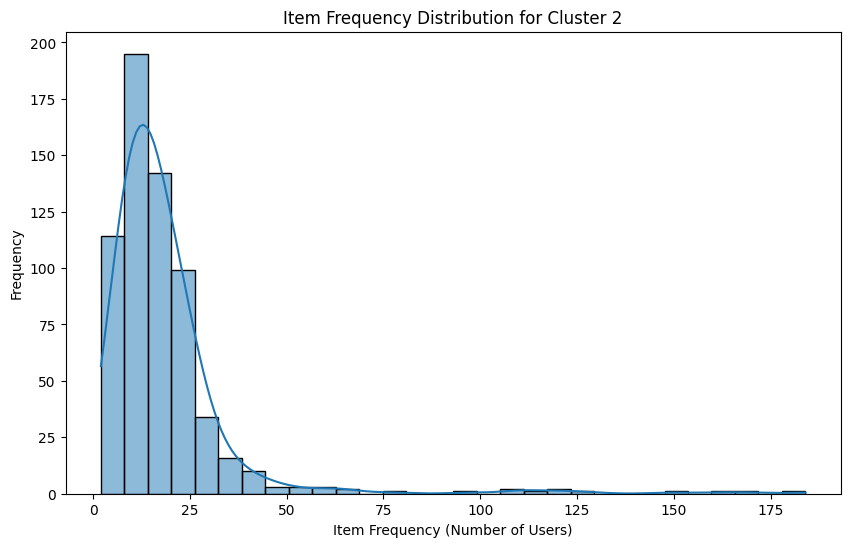

Cluster 2: 240 rules generated.

Processing Cluster 5...
Sparsity of Cluster 5: 0.9857, ize of Cluster is: 1548


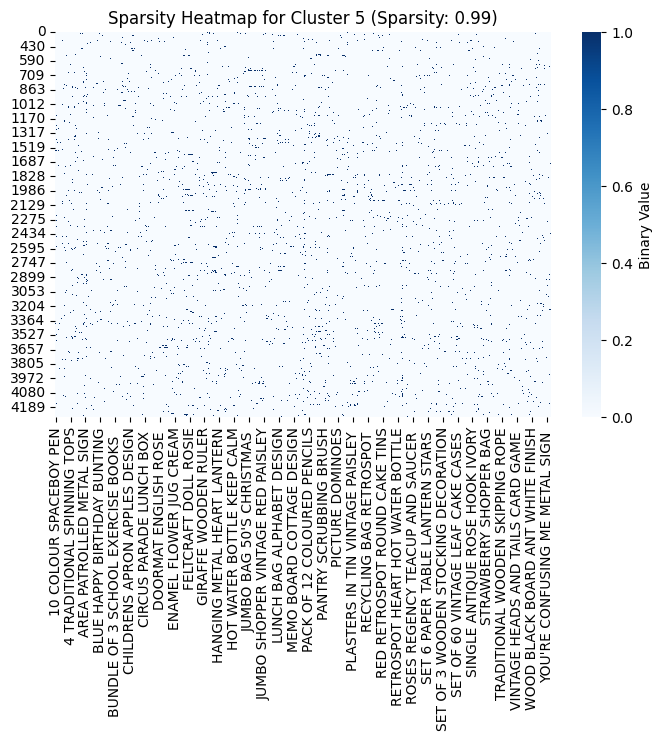

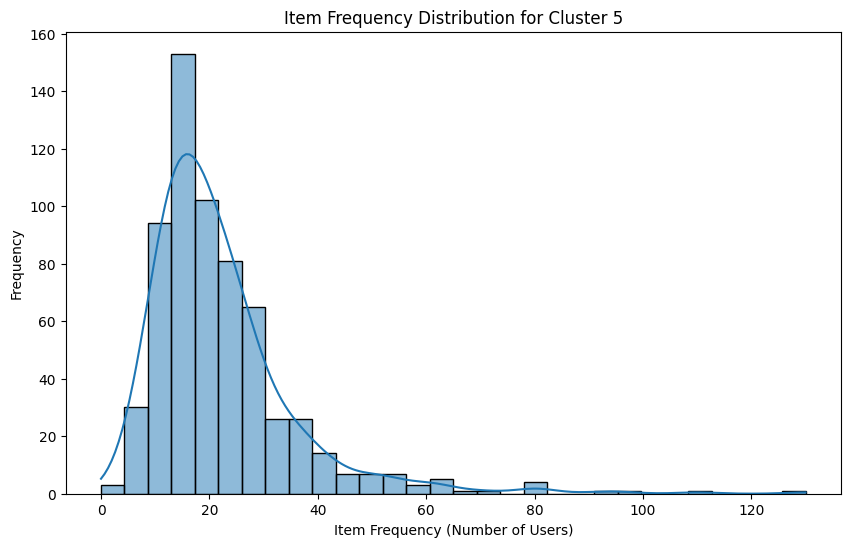

No frequent itemsets found in Cluster 5.

Processing Cluster 9...
Sparsity of Cluster 9: 0.9343, ize of Cluster is: 222


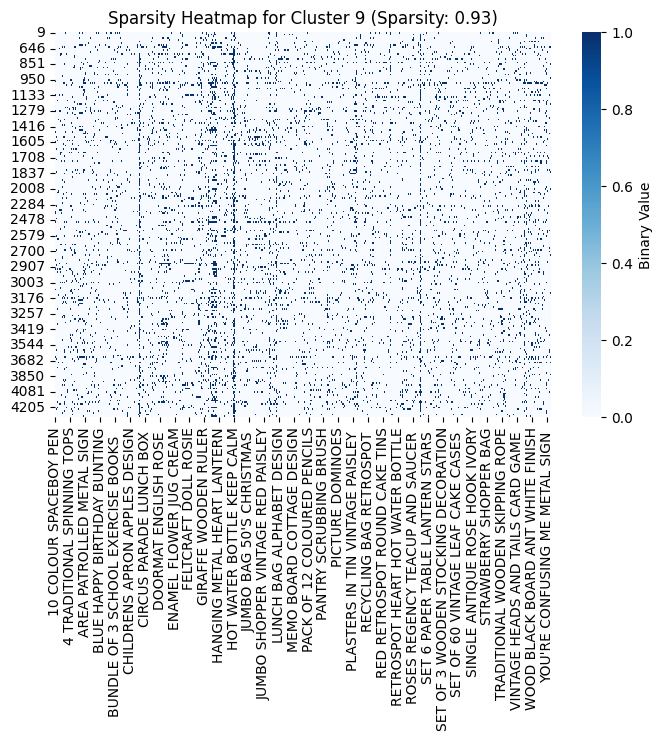

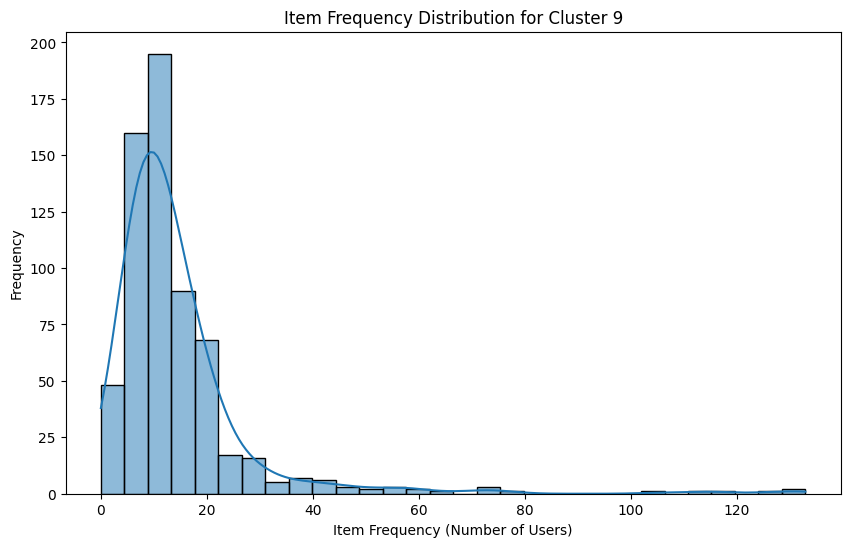

Cluster 9: 2 rules generated.

Processing Cluster 11...
Sparsity of Cluster 11: 0.9564, ize of Cluster is: 116


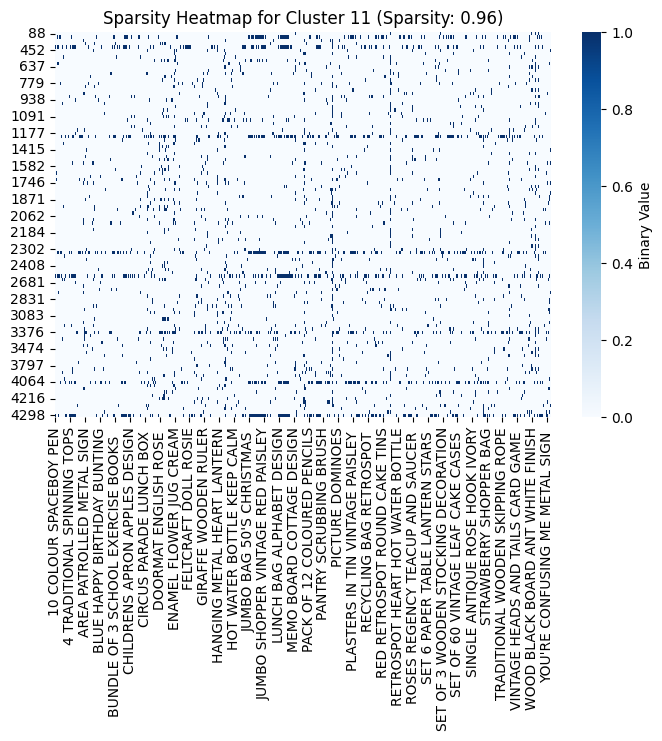

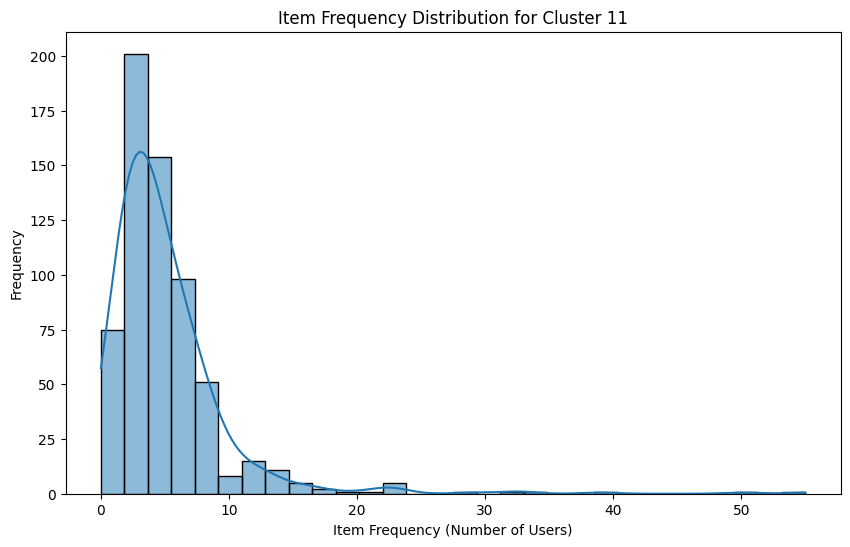

Cluster 11: 0 rules generated.

Processing Cluster 12...
Sparsity of Cluster 12: 0.9361, ize of Cluster is: 279


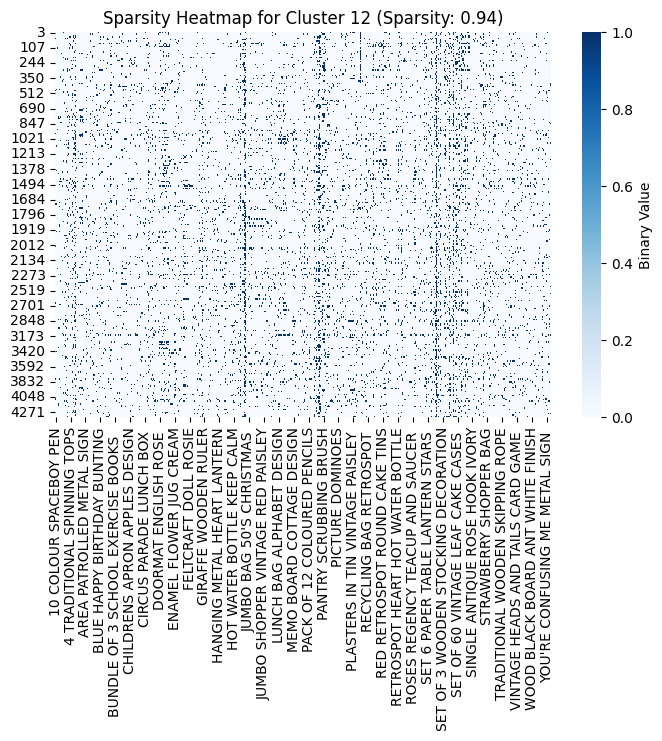

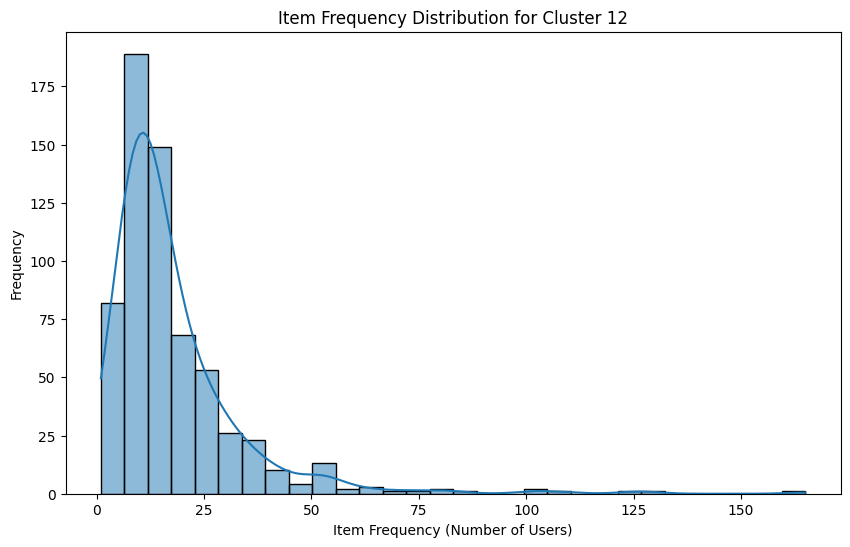

Cluster 12: 0 rules generated.

Processing Cluster 15...
Sparsity of Cluster 15: 0.9649, ize of Cluster is: 362


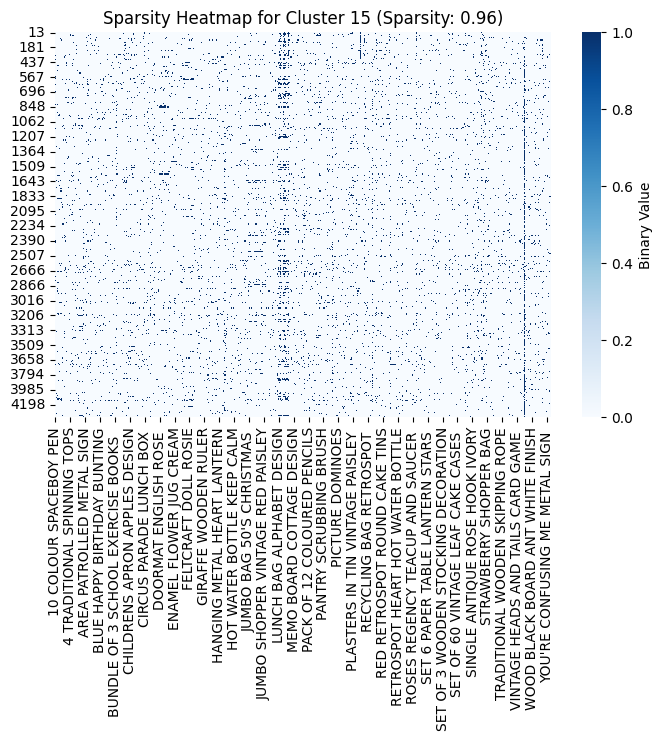

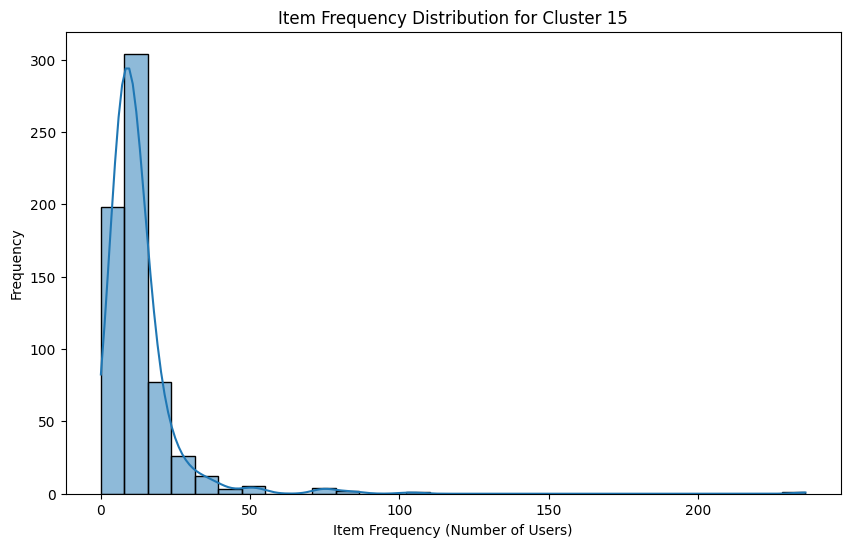

Cluster 15: 0 rules generated.

Processing Cluster 18...
Sparsity of Cluster 18: 0.8263, ize of Cluster is: 167


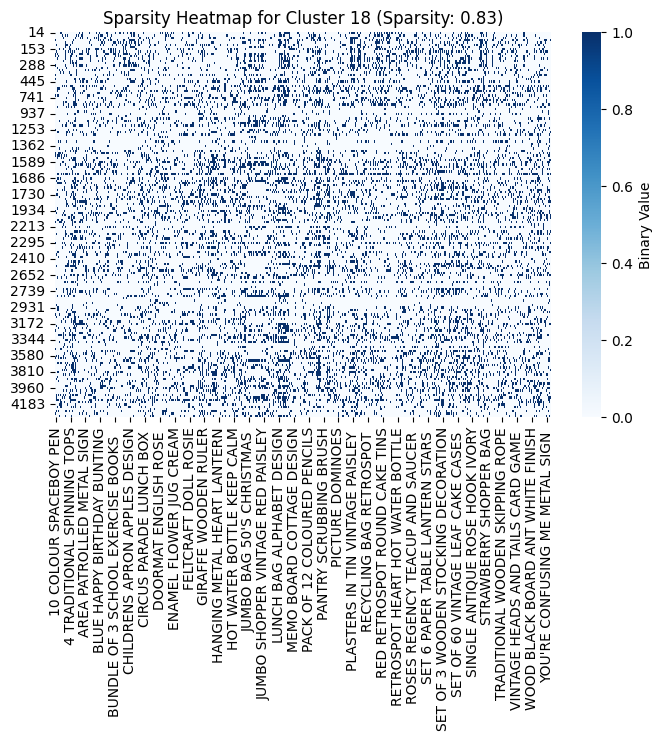

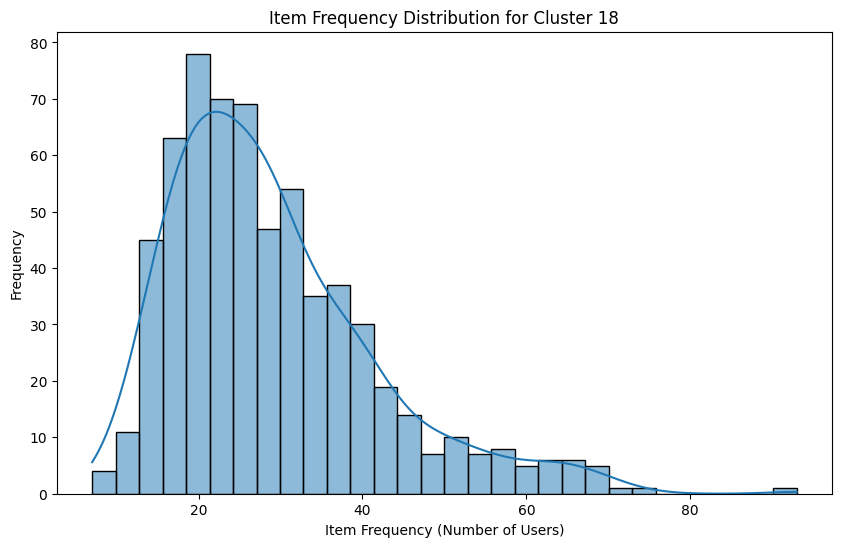

Cluster 18: 0 rules generated.

Processing Cluster 19...
Sparsity of Cluster 19: 0.9638, ize of Cluster is: 234


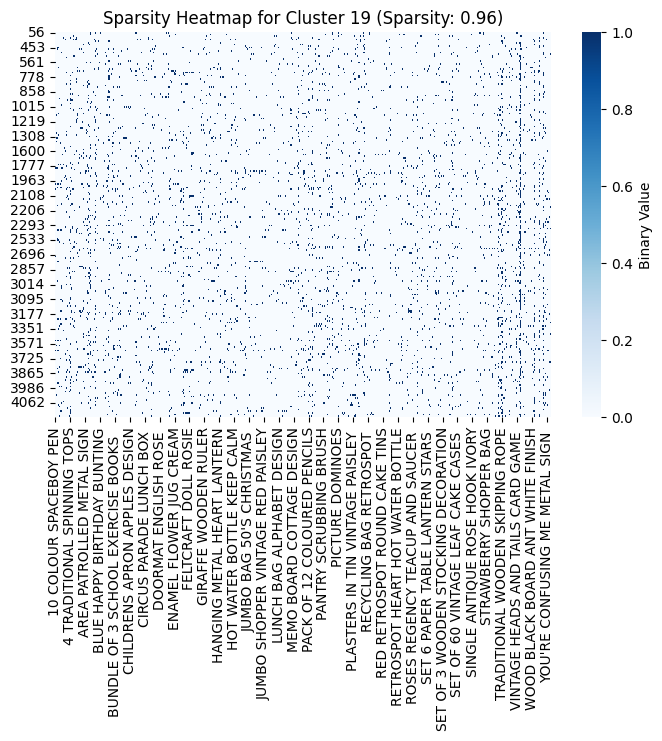

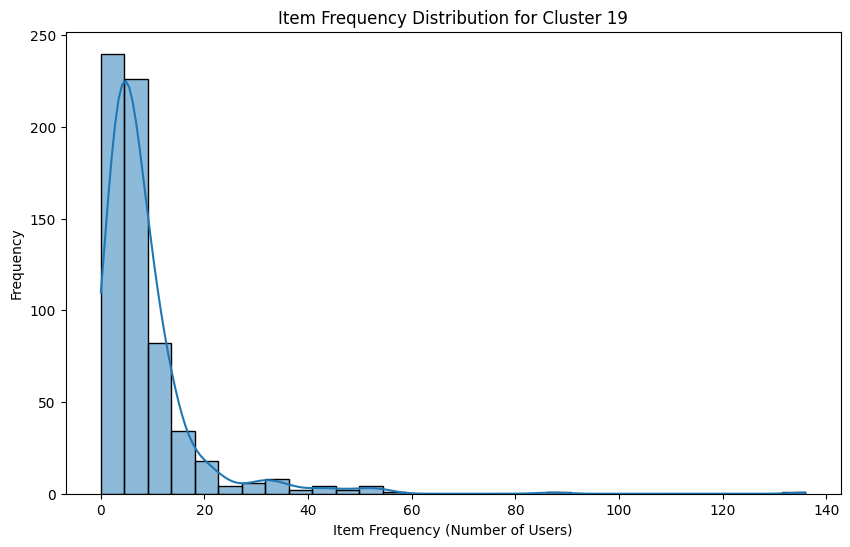

Cluster 19: 0 rules generated.

Processing Cluster 24...
Sparsity of Cluster 24: 0.9492, ize of Cluster is: 192


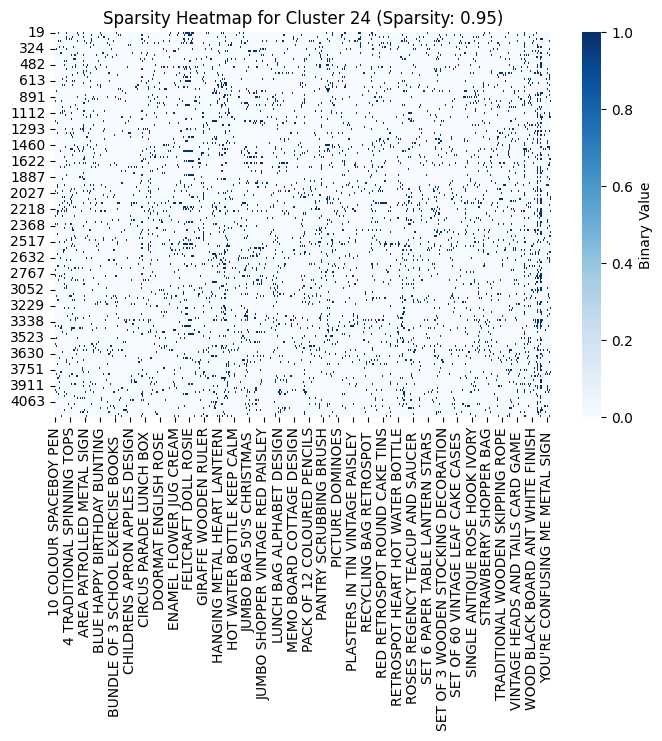

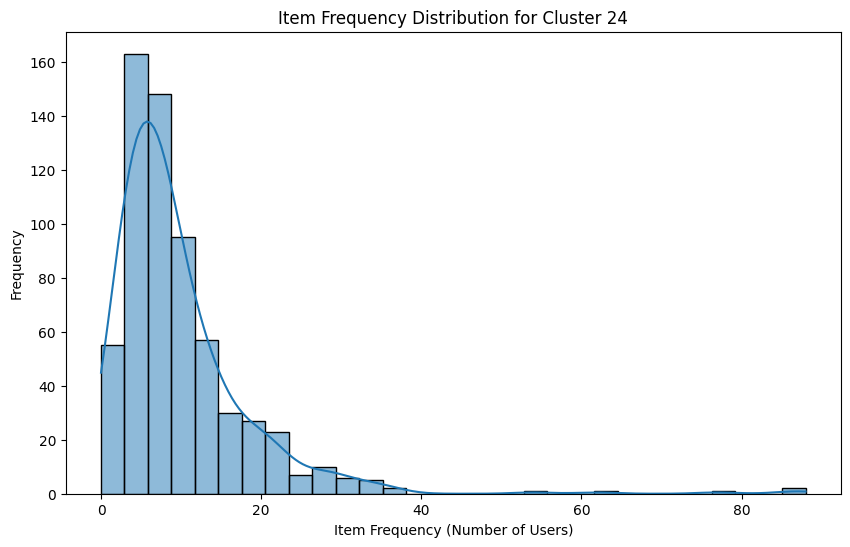

Cluster 24: 0 rules generated.


In [283]:
cluster_results = find_clusters_rules(transactions, min_support=0.4)



In [284]:
original_min_support = 0.05
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)


number of rules shared with baseline approach: 52
ratio of shared rules: 0.21487603305785125


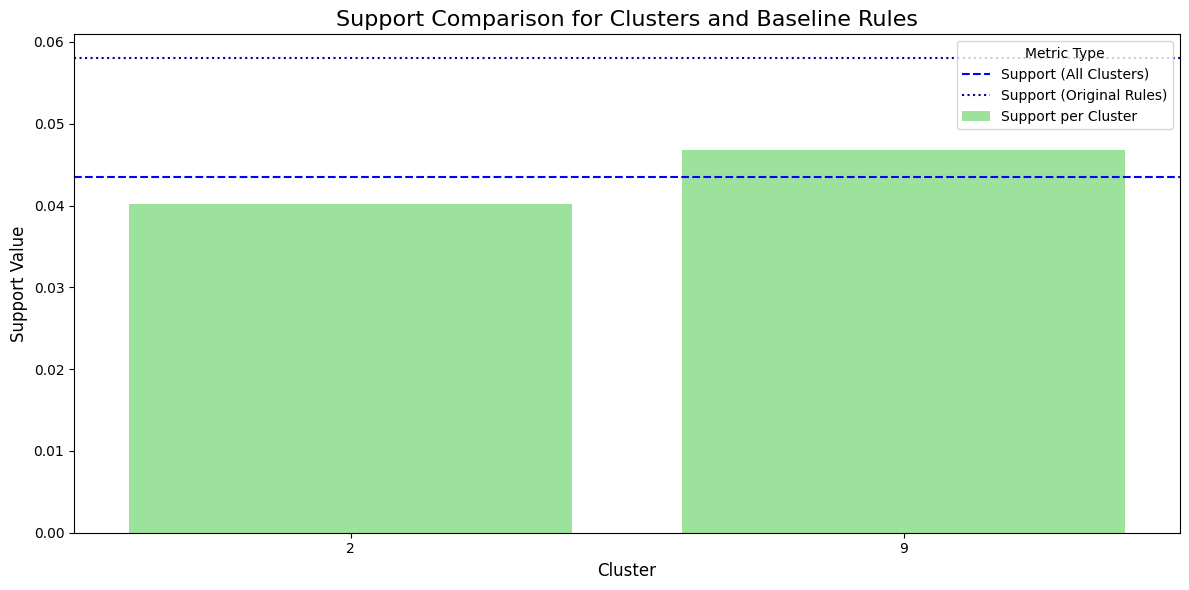

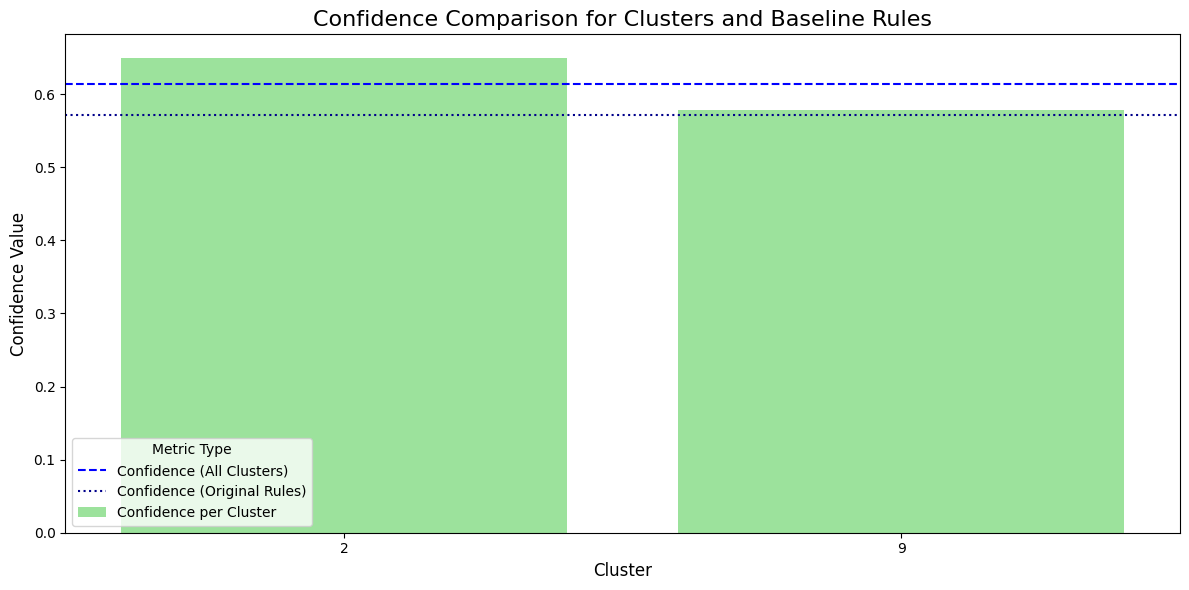

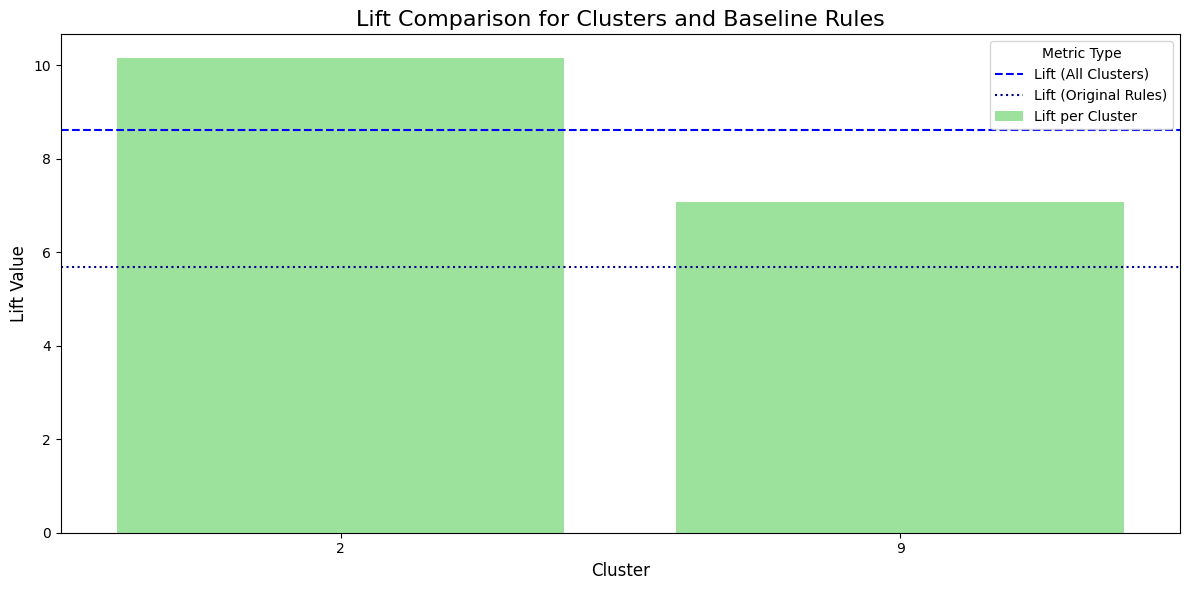

In [285]:
plot_rules_comparison(all_rules_df)